# Introduction

This notebook contains the approach to predict the winner of T20 cricket match. The problem statement is the part of the American Express Campus Challenge 2024.

The details of problem statement and data can be found [here.](https://www.kaggle.com/datasets/abhishekgautam12/american-express-campus-super-bowl-challenge-2024?select=664376cd0ff2c_amex_campus_challenge_2024_modeling_problem_statement_vf_1.pdf)

This notebook involves and extensive use of boosting algorithms like XGB, LightGBM, GBM and CatBoost, feature engineering,model stacking and Hyperparameter Tuning.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
#file paths

#primary training dataset
train_df_path= '/kaggle/input/american-express-campus-super-bowl-challenge-2024/663e2b6d54457_train_data_with_samplefeatures.csv'

#additional data
match_df_path = '/kaggle/input/american-express-campus-super-bowl-challenge-2024/664389efa0868_match_level_scorecard.csv'
bowler_df_path = '/kaggle/input/american-express-campus-super-bowl-challenge-2024/663e2b2c60743_bowler_level_scorecard.csv' 
batsman_df_path = '/kaggle/input/american-express-campus-super-bowl-challenge-2024/663e2b548c98c_batsman_level_scorecard.csv'

#test data
test_df_path = '/kaggle/input/american-express-campus-super-bowl-challenge-2024/6644a1e287df6_test_data_with_samplefeatures.csv'

In [3]:
pd.set_option('display.max_columns', 50)
## Print multiple output per cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Data and Description

In [4]:
#reading data
train_data = pd.read_csv(train_df_path)
test_data = pd.read_csv(test_df_path)

match_lvl_data = pd.read_csv(match_df_path)
bowler_lvl_data = pd.read_csv(bowler_df_path)
batsman_lvl_data = pd.read_csv(batsman_df_path)

In [5]:
train_data.shape

(948, 23)

Description of the each columns is as follows :
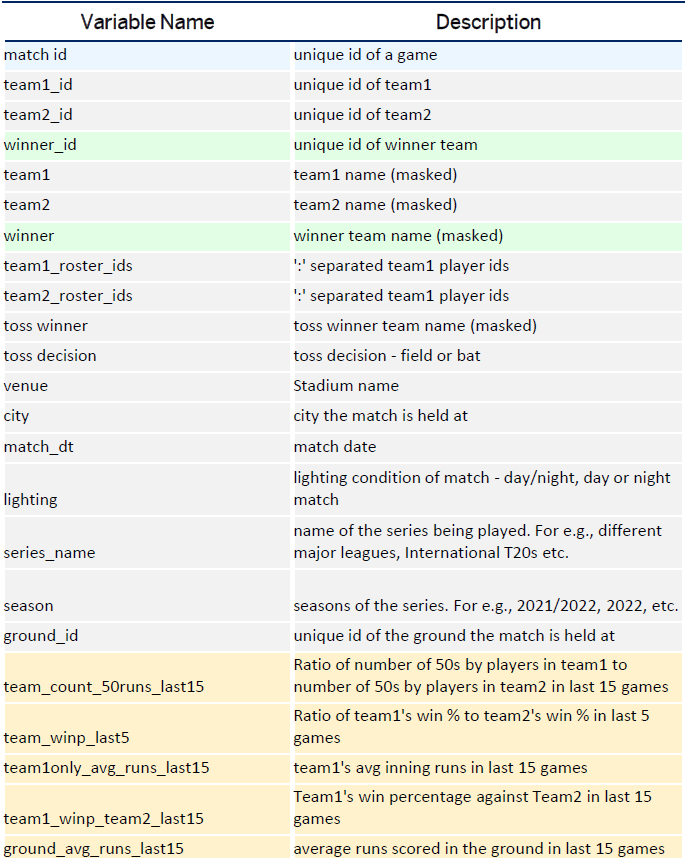

In [6]:
match_lvl_data.shape

(1689, 30)

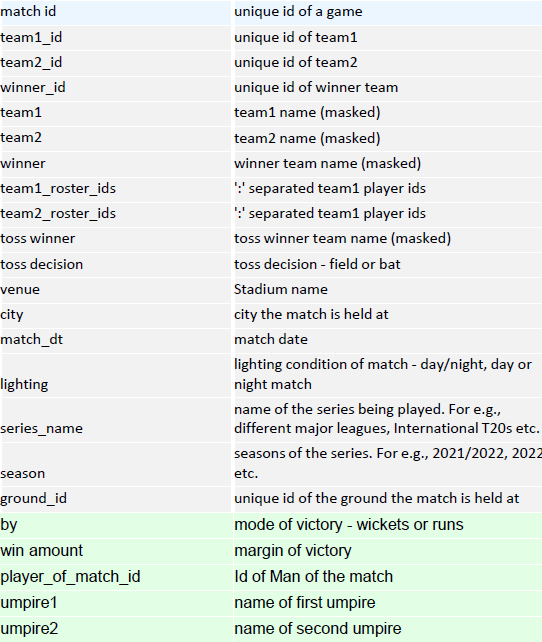
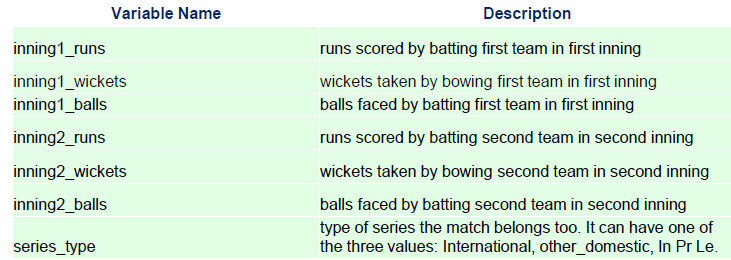

In [7]:
batsman_lvl_data.shape

(18539, 18)

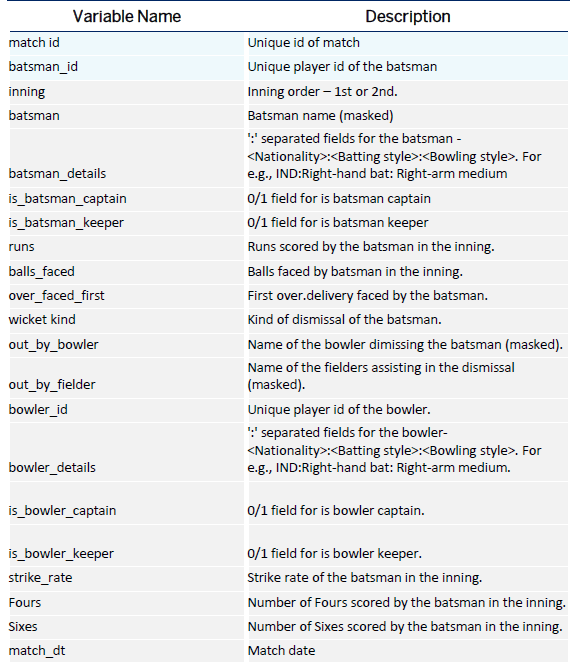

In [8]:
bowler_lvl_data.shape

(18539, 18)

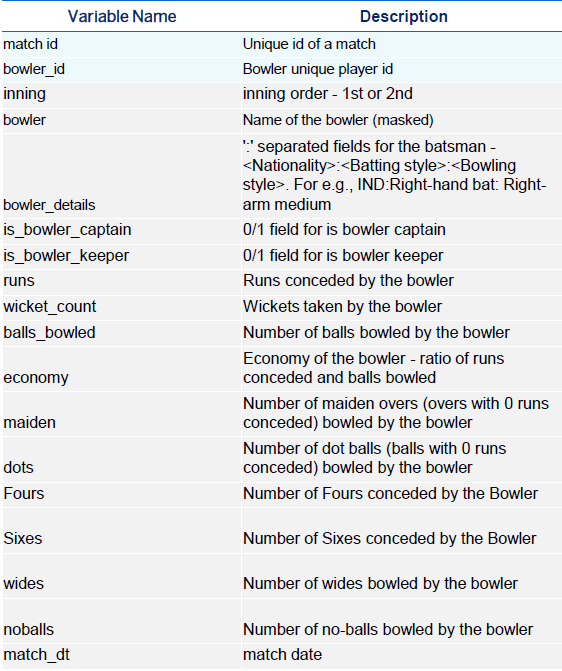

# CheatCode 1 - given by Amex

Below is the code given by the American Express to compute the given features that were engineered using additional data.

In [11]:
## Creating a binary winner column - 0 if team1 wins, else 1
train_data['winner_01'] = train_data.apply(lambda x: 0 if (x['team1']==x['winner']) else 1, axis=1)

> Helper Functions

In [6]:
# ## Code to plot RnP


from matplotlib import pyplot as plt
plt.style.use('seaborn');
import re

def createRnP(X_12, feature, N=5, ylim_lb=0.3, ylim_ub=0.7):
    '''
    Rank and Plot of input feature on the input data. The y-axis shows %team1 wins in each bucket.
    
    Parameters-
    1. X_12: dataset to build the RnP on. 
    2. feature: Feature to build RnP of.
    3. N: number of bins on x-axis. Default 5.
    4. ylim_lb: lower bound of y axis on plot.
    5. ylim_ub: upper bound of y axis on plot.
    
    Output-
    1. Rank and Plot
    
    Returns- None
    '''
    df = X_12.copy()
    df[f'{feature}_bin'] = df[feature].rank(pct=True)//(1/N) # divide feature values for all games in 5 equi-volume buckets.
    df['count'] = 1
    df['team1_win%'] = df['winner_01'].apply(lambda x: 1-x) # invert winner_01 to get team1 winner indicator
    df['team2_win%'] = df['winner_01'].copy()
    df[f'{feature}_min'] = df[feature].copy()
    df[f'{feature}_max'] = df[feature].copy()
    df_g = df.groupby(f'{feature}_bin').agg({'team1_win%':'mean', 'team2_win%':'mean', 'count':'sum', f'{feature}_min':'min',\
                                            f'{feature}_max':'max'}).reset_index()
    N = min(N,df_g.shape[0])
    blue_bar = df_g['team1_win%'].values.tolist()
    ind = np.arange(N)
    # plotting starts
    plt.figure(figsize=(10,5));
    plt.bar(ind, blue_bar, label='Team 1 win%');
    plt.axhline(y=0.5, linewidth=0.5, color='k', linestyle = '--')
    xlabel = re.sub('team_','ratio_',feature)
    plt.xlabel(f'{xlabel} (team1 / team2) bins');
    plt.ylabel('Win %');
    plt.title(f'RnP - {feature} vs win');
    df_g['xticks'] = df_g.apply(lambda x: str(round(x[f'{feature}_min'],2)) + ' - ' + str(round(x[f'{feature}_max'],2)), axis=1)
    plt.xticks(ind, df_g['xticks']);
    plt.ylim([ylim_lb,ylim_ub]);
    plt.legend(loc='best');
    x2,x1 = blue_bar[-1],blue_bar[0]
    slope = x2/x1
    if slope < 1:
        slope = 1/slope
        x1,x2 = x2,x1
    print('slope:', round(x2,2),'/',round(x1,2), '= ',round(slope,2))
    plt.show();


/tmp/ipykernel_33/1681831091.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn');


In [7]:
def giveLastNgamesPlayer(player_id, date, n, bat_or_bowl):
    '''
    Function to get last n games stats of a player before an input date.
    
    Input-
    1. player_id: id of the player to get historical data.
    2. date: date to look-back and get n games. Stats returned are before this input date.
    3. n: Number of historical games stats to return.
    4. bat_or_bowl: Kind of stats to return. {'bat': batting stats to return, 'bowl': bowling stats to return}
    
    Output-None
    
    Returns- dataframe having bowling/batting stats from last n games of a player before an input date. 
    The results are sorted by date.
    '''
    if bat_or_bowl == 'bat':
        df_topick = batsman_lvl_data
        id_col = 'batsman_id'
    else:
        df_topick = bowler_lvl_data
        id_col = 'bowler_id'
        
    return df_topick[(df_topick['match_dt']<date)&(df_topick[id_col]==float(player_id))]\
                .sort_values(by='match_dt', ascending=False).head(n)


In [8]:
# ## Feature creation

# ### 1. team_count_50runs_last15 <br>
# Ratio of number of 50s by players in team1 to number of 50s by players in team2 in last 15 games


def no50sLastn(player_list, date, n):
    '''
    Function to get total number of 50s scored by players in the roster of a team in last n games.
    
    Input-
    1. player_list: ':' separated list of player ids in the roster of a team.
    2. date: match date of the game to calculate this feature.
    3. n: Number of games to look-back and create this feature.
    
    Output-None
    
    Returns- int value denoting sum of 50s scored by all players in the roster.
    '''
    
    player_list = str(player_list).split(':') # split string of ':' separated ids into a list of ids
    res_list = []
    for player in player_list: # loop over each player_id in roster
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bat') # getting batting stats from last n games for each player.
        df_rel['gte_50runs'] = np.where(df_rel['runs']>=50, 1, 0) # binary indicator to denote whether the player scored a 50 in the game (runs>=50).
        res_list.append(np.nansum(df_rel['gte_50runs']))# Sum up number of 50s for the player and append to a list. We will do this for all players.
    return np.nansum(res_list)# Sum up values of the list which is sum of 50s by all players in the roster.



> Ready to use Features

In [ ]:
# Computing number of 50 runs in last 15 games for team1 for train dataset.
train_data['team1_count_50runs_last15'] = train_data.apply(lambda x: \
            no50sLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
# Computing number of 50 runs in last 15 games for team2 for train dataset.
train_data['team2_count_50runs_last15'] = train_data.apply(lambda x: \
            no50sLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)


# Taking ratio of (number of 50 runs in last 15 games for team1) to (number of 50 runs in last 15 games for team2). Adding 1 to handle divide by zero exceptions.
train_data['team_count_50runs_last15'] = (train_data['team1_count_50runs_last15']+1)/(train_data['team2_count_50runs_last15']+1)
train_data.drop(columns=['team1_count_50runs_last15','team2_count_50runs_last15'], inplace=True) # dropping intermediate columns

## Doing similar process for test dataset

test_data['team1_count_50runs_last15'] = test_data.apply(lambda x: \
            no50sLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
test_data['team2_count_50runs_last15'] = test_data.apply(lambda x: \
            no50sLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)
test_data['team_count_50runs_last15'] = (test_data['team1_count_50runs_last15'])/(test_data['team2_count_50runs_last15']+1)
test_data.drop(columns=['team1_count_50runs_last15','team2_count_50runs_last15'], inplace=True)
test_data.shape
test_data.head(2)

In [ ]:
#for match level data
match_lvl_data['team1_count_50runs_last15'] = match_lvl_data.apply(lambda x: \
            no50sLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
match_lvl_data['team2_count_50runs_last15'] = match_lvl_data.apply(lambda x: \
            no50sLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)
match_lvl_data['team_count_50runs_last15'] = (match_lvl_data['team1_count_50runs_last15'])/(match_lvl_data['team2_count_50runs_last15']+1)
match_lvl_data.drop(columns=['team1_count_50runs_last15','team2_count_50runs_last15'], inplace=True)


In [254]:
# Ratio of team1's win % to team2's win % in last 5 games
def winpLastn(team_id, date, n):
    '''
    Get a team's win % in last n games. If a team has won 3 game out of their last 5, win% is 60%.
    
    Input-
    1. team_id: ID of the team to get their last n games and winner information from those games.
    2. date: match date from which to get last n historical games.
    3. n: look-back window of games.
    
    Output- None
    
    Returns- Float value denoting win% of the team in last n games.
    '''
    # filter out games with either team1/2_id as input team id, match_dt being before current game's date, sort desc by date, and get top n rows (games)
    df_rel = match_lvl_data[(match_lvl_data['match_dt']<date)&\
                      ((match_lvl_data['team1_id']==team_id)|(match_lvl_data['team2_id']==team_id))]\
                        .sort_values(by='match_dt', ascending=False).head(n) 
    win_count = df_rel[df_rel['winner_id']==team_id].shape[0] # count number of rows having winner as the input team
    if win_count == 0:
        return 0
    return round(win_count*100/df_rel.shape[0], 2) # return win% rounded to two decimal points

In [ ]:
# Compute team1's win% in last 5 games
train_data['team1_winp_last5'] = train_data.progress_apply(lambda x: \
                                  winpLastn(x['team1_id'], x['match_dt'], 5), axis=1)
# Compute team2's win% in last 5 games
train_data['team2_winp_last5'] = train_data.progress_apply(lambda x: \
                                  winpLastn(x['team2_id'], x['match_dt'], 5), axis=1)

# Take the ratio of (team1's win% in their last 5 games)/(team2's win% in their last 5 games). Adding 1 to avoid divide by zero error
train_data['team_winp_last5'] = (train_data['team1_winp_last5']+1)/(train_data['team2_winp_last5']+1)
train_data.drop(columns=['team1_winp_last5', 'team2_winp_last5'], inplace=True) # drop intermediate columns

## Similar process for test data

test_data['team1_winp_last5'] = test_data.progress_apply(lambda x: \
            winpLastn(team_id=x['team1_id'], date=x['match_dt'], n=5), axis=1)
test_data['team2_winp_last5'] = test_data.progress_apply(lambda x: \
            winpLastn(team_id=x['team2_id'], date=x['match_dt'], n=5), axis=1)
test_data['team_winp_last5'] = (test_data['team1_winp_last5']+1)/(test_data['team2_winp_last5']+1)
test_data.drop(columns=['team1_winp_last5','team2_winp_last5'], inplace=True)
test_data.shape
test_data.head(2)

In [303]:
# ### 3. teamonly_avg_runs_last15 <br>
# team1's avg inning runs in last 15 games

## derived feature computed using toss winner & toss decision to denote the inning team1 bats.
# If team1 won the toss and chose to bat or team2 won the toss and chose to bowl, the feature takes the value 1, else 2.
match_lvl_data['team1_bat_inning'] = np.where( ((match_lvl_data['team1']==match_lvl_data['toss winner'])&(match_lvl_data['toss decision']=='bat'))|\
                                               ((match_lvl_data['team2']==match_lvl_data['toss winner'])&(match_lvl_data['toss decision']=='field')) , 1, 2)



In [ ]:
match_lvl_data.head(2)

In [17]:
def teamAvgRunsLastn(team_id, date, n):
    '''
    Function to calculate a team's average runs in their last n games.
    
    Input-
    1. team_id: ID of the team to calculate average runs.
    2. date: match date of the current game for which the feature is calculated.
    3. n: look-back window of games for the team.
    
    Output- None
    
    Return- Float value denoting average of runs scored by team1 in their last n games.
    '''
    # filter out games with either team1/2_id as input team_id, match date less than current game's input date, sort desc by date, and top n rows (games) returned
    df_rel = match_lvl_data[(match_lvl_data['match_dt']<date)&\
                      ((match_lvl_data['team1_id']==team_id)|(match_lvl_data['team2_id']==team_id))]\
                        .sort_values(by='match_dt', ascending=False).head(n)
    # combine two dataframes - one where input team is batting first, and another one where input team is batting second.
    df_rel = pd.concat([ df_rel[df_rel['team1_bat_inning']==1][['inning1_runs']].rename(columns={'inning1_runs':'runs'}), \
                         df_rel[df_rel['team1_bat_inning']==2][['inning2_runs']].rename(columns={'inning2_runs':'runs'}) ] )
    return df_rel['runs'].mean() # return mean of the combined dataframe.


In [11]:
# Compute average runs scored by team1 in their last 15 games for train data.
train_data['team1only_avg_runs_last15'] = train_data.apply(lambda x: \
                                  teamAvgRunsLastn(x['team1_id'], x['match_dt'], 15), axis=1)


In [ ]:
# Similarly for test data.
test_data['team1only_avg_runs_last15'] = test_data.progress_apply(lambda x: \
            teamAvgRunsLastn(x['team1_id'], x['match_dt'], 15), axis=1)
test_data.shape
test_data.head(2)

In [ ]:
train_data.shape
train_data.head(2)

In [ ]:
# ### 4. teamone_winp_teamtwo_last15 <br>
# Team1's win percentage againts Team2 in last 15 games

def winpCrossLastn(team1_id, team2_id, date, n):
    '''
    Function to compute team1's win% against team2 from the current game in their past n encounters.
    
    Input-
    1. team1_id: ID of team1 to calculate win% of.
    2. team2_id: ID of team2 to calculate win% against.
    3: date: match date of the current game for which the feature is to be calculated.
    4. n: look-back window of games for both these teams.
    
    Output- None
    
    Returns- Float value denoting team1's win% against team2 in their past n games against each other.
    '''
    # filter out games where either team1_id is input team1 and team2_id is input team2, or where team2_id is input team1 and team1_id is input team2.
    # Also, match date is less than current games's input date, sort desc by date and get top n rows (games)
    df_rel = match_lvl_data[(match_lvl_data['match_dt']<date)&\
                      (((match_lvl_data['team1_id']==team1_id)&(match_lvl_data['team2_id']==team2_id))|((match_lvl_data['team1_id']==team2_id)&(match_lvl_data['team2_id']==team1_id)))]\
                        .sort_values(by='match_dt', ascending=False).head(n)
    win_count = df_rel[df_rel['winner_id']==team1_id].shape[0] # Counting number of rows (games) where winner is input team1.
    if win_count == 0:
        return 0
    return round(win_count*100/df_rel.shape[0], 2) # return Float denoting team1's win% against team2 in past n games rounded to 2 decimal places.


In [ ]:
# Compute team1 win% against team2 in their past 15 encounters for train data.
train_data['team1_winp_team2_last15'] = train_data.progress_apply(lambda x: \
                                  winpCrossLastn(x['team1_id'], x['team2_id'], x['match_dt'], 5), axis=1)

In [ ]:
train_data.shape
train_data.head(2)

In [ ]:
# Similarly for test data.
test_data['team1_winp_team2_last15'] = test_data.progress_apply(lambda x: \
                                  winpCrossLastn(x['team1_id'], x['team2_id'], x['match_dt'], 5), axis=1)

In [ ]:
def avgRunsGround(ground_id, date, n):
    '''
    Function to calculate average runs scored in ground/venue.
    
    Input-
    1. ground_id: ID of the ground to calculate the feature for.
    2. date: match date of the current game to calculate the feature for.
    3. n: look-back window of games for the ground.
    
    Output- None
    
    Returns- Average runs scored in the ground.
    '''
    # filter out games with ground_id being the input ground_id and date earlier than current game's input date. Sort desc by date, and select top n rows (games).
    df_rel = match_lvl_data[(match_lvl_data['match_dt']<date)&(match_lvl_data['ground_id']==ground_id)].sort_values(by='match_dt', ascending=False).head(n)
    df_rel['avg_runs_inn'] = (df_rel['inning1_runs']+df_rel['inning2_runs'])/2 # take the mean of inning1_runs and inning2_runs in a separate column.
    return df_rel['avg_runs_inn'].mean() # Return the mean value of the computed column above.


In [ ]:
## Calculate average runs in the ground for last 15 games hosted in that venue for train data.
train_data['ground_avg_runs_last15'] = train_data.progress_apply(lambda x: \
                                  avgRunsGround(x['ground_id'], x['match_dt'], 15), axis=1)
## Similarly for test data.
test_data['ground_avg_runs_last15'] = test_data.progress_apply(lambda x: \
                                  avgRunsGround(x['ground_id'], x['match_dt'], 15), axis=1)


The above code was given by Amex and we will use some of the functions defined above to generate more features

# RNP of the given features

slope: 0.6 / 0.39 =  1.53


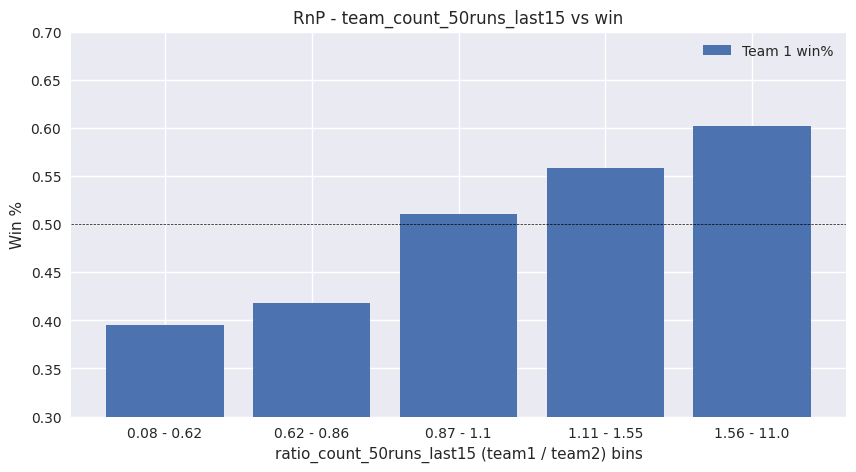

In [13]:
# RnP of team_count_50runs_last15 computed over the train data. Slope denotes ratio of right most bin to left most bin.
createRnP(train_data, 'team_count_50runs_last15')

slope: 0.58 / 0.4 =  1.47


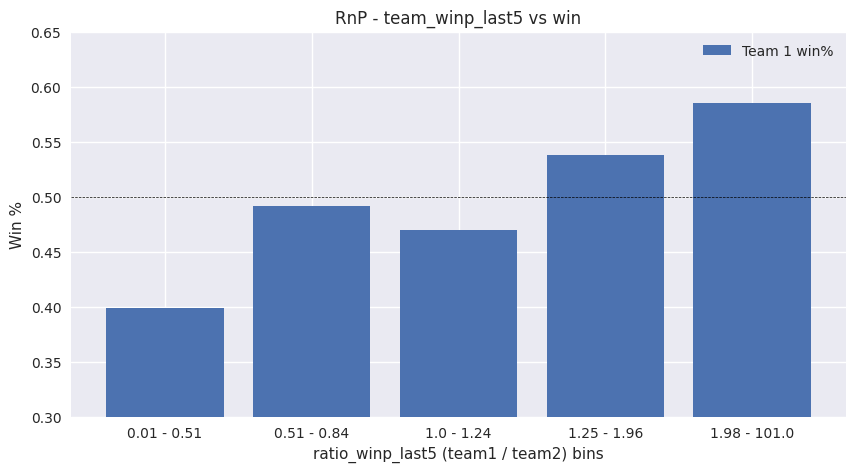

In [14]:
# RnP of team_winp_last5 computed over the train data.
createRnP(train_data, 'team_winp_last5', ylim_ub=0.65)

slope: 0.52 / 0.45 =  1.16


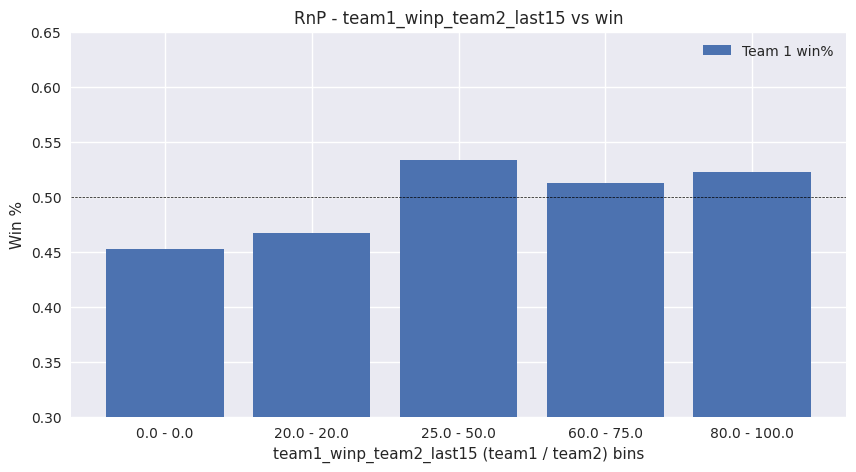

In [15]:
createRnP(train_data, 'team1_winp_team2_last15', ylim_ub=0.65)

# PreProcess Data

In [16]:
## Creating a binary winner column - 0 if team1 wins, else 1
train_data['winner_01'] = train_data.apply(lambda x: 0 if (x['team1']==x['winner']) else 1, axis=1)

In [8]:
## Toss winner to numerical - 1 if team2 wins, else 0

train_data['toss_winner_01'] = np.where(train_data['toss winner']==train_data['team2'], 1, 0)
test_data['toss_winner_01'] = np.where(test_data['toss winner']==test_data['team2'], 1, 0)

In [9]:
## Toss decision - categorical - 1 if winner bats, 0 otherwise

train_data['toss_decision_01'] = np.where(train_data['toss decision']=='bat', 1, 0)
test_data['toss_decision_01'] = np.where(test_data['toss decision']=='bat', 1, 0)

# Feature Engineering

> # 1. Ground Level Features

> Wickets on ground

In [330]:
# function to given match data before a date

def giveLastGames_ground(ground_id, date, n= 15):
    '''
    Function to return match_lvl_data of a particular ground/venue before a given date.
    
    Input-
    1. ground_id: ID of the ground.
    2. date: match date of the current game.
    3. n: look back window for number of matches(default = 15)
    
    Output- None
    
    Returns- dataframe having match stats from last n games on the particular ground before an input date. 
    The results are sorted by date.
    '''
    df_rel = match_lvl_data[(match_lvl_data['match_dt'] < date) &\
                           (match_lvl_data['ground_id'] == ground_id)].head(n).sort_values(by='match_dt', ascending=False).head(n)
    
    return df_rel

In [20]:
def avgWicketsGround(ground_id, date, n):
    '''
    Function to calculate average wickets in ground/venue.
    
    Input-
    1. ground_id: ID of the ground to calculate the feature for.
    2. date: match date of the current game to calculate the feature for.
    3. n: look-back window of games for the ground.
    
    Output- None
    
    Returns- Average wickets in the ground.
    '''
    # filter out games with ground_id being the input ground_id and date earlier than current game's input date. Sort desc by date, and select top n rows (games).
    df_rel = giveLastGames_ground(ground_id, date, n= 15)
    df_rel['avg_wickets_inn'] = (df_rel['inning1_wickets']+df_rel['inning2_wickets'])/2 # take the mean of inning1_runs and inning2_runs in a separate column.
    return df_rel['avg_wickets_inn'].mean() # Return the mean value of the computed column above.


In [21]:
## Calculate average runs in the ground for last 15 games hosted in that venue for train data.
train_data['ground_avg_wickets_last15'] = train_data.apply(lambda x: \
                                  avgWicketsGround(x['ground_id'], x['match_dt'], 15), axis=1)
## Similarly for test data.
test_data['ground_avg_wickets_last15'] = test_data.apply(lambda x: \
                                  avgWicketsGround(x['ground_id'], x['match_dt'], 15), axis=1)
                                  

> ratio of runs scored by batting first to batting second team on that ground in last n games

In [22]:
def avg_inning_1to2_Ground(ground_id, date, n):
    '''
    Function to calculate avg ratio of inning1 to inning2 runs in ground/venue.
    
    Input-
    1. ground_id: ID of the ground to calculate the feature for.
    2. date: match date of the current game to calculate the feature for.
    3. n: look-back window of games for the ground.
    
    Output- None
    
    Returns- avg ratio of inning1 to inning2 runs in ground/venue.
    '''
    # filter out games with ground_id being the input ground_id and date earlier than current game's input date. Sort desc by date, and select top n rows (games).
    df_rel = giveLastGames_ground(ground_id, date, n= 15)
    df_rel['ratio_innings_runs'] = (df_rel['inning1_runs']/df_rel['inning2_runs']) # take the mean of inning1_runs and inning2_runs in a separate column.
    return df_rel['ratio_innings_runs'].mean() # Return the mean value of the computed column above.


In [23]:
train_data['inning_runs_ratio'] = train_data.apply(lambda x: \
                                  avg_inning_1to2_Ground(x['ground_id'], x['match_dt'], 15), axis=1)
test_data['inning_runs_ratio'] = test_data.apply(lambda x: \
                                  avg_inning_1to2_Ground(x['ground_id'], x['match_dt'], 15), axis=1)
    

As a cricket fan, we know the bowling first team on a place where dew is there has an advantage especially at night or evening match. Therefore it will have advantage.

Hypothesis : The bowling first team in night or day/night matches have a higher chance of winning that match.


In [24]:
## toss winner choosed to field first in night or day/night match
field_first_night = train_data[(match_lvl_data['toss decision'] == 'field') &\
                               ((match_lvl_data['lighting'] == 'night match') |\
                                (match_lvl_data['lighting'] == 'day/night match'))]
# how many times the field first team won the matches that happened at night or day/night ligthing
pd.Series((field_first_night['toss winner'] == field_first_night['winner'])).value_counts() / field_first_night.shape[0]


/tmp/ipykernel_33/1001540787.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  field_first_night = train_data[(match_lvl_data['toss decision'] == 'field') &\


False    0.535014
True     0.464986
Name: count, dtype: float64

**Hypothesis was wrong**

> successful chases on ground 

In [25]:
def successful_chase_ratio(ground, date, n = 15):
    
    def_rel = giveLastGames_ground(ground, date, n)
    succ_chase_count = def_rel[((def_rel['toss decision'] == 'bat') & \
                               (def_rel['toss winner'] != def_rel['winner'])) |\
                              ((def_rel['toss decision'] == 'field') & \
                               (def_rel['toss winner'] == def_rel['winner']))].shape[0]
    if succ_chase_count == 0:
        return 0
    return round(succ_chase_count/def_rel.shape[0], 2)

In [26]:
train_data['succ_chase_r_ground_last_15'] = train_data.apply(lambda x: 
                                                            successful_chase_ratio(x['ground_id'],x['match_dt'],15), axis = 1)

In [27]:
test_data['succ_chase_r_ground_last_15'] = train_data.apply(lambda x: 
                                                            successful_chase_ratio(x['ground_id'],x['match_dt'],15), axis = 1)

> Effect of lighting in predecting winner

<Axes: xlabel='lighting', ylabel='count'>

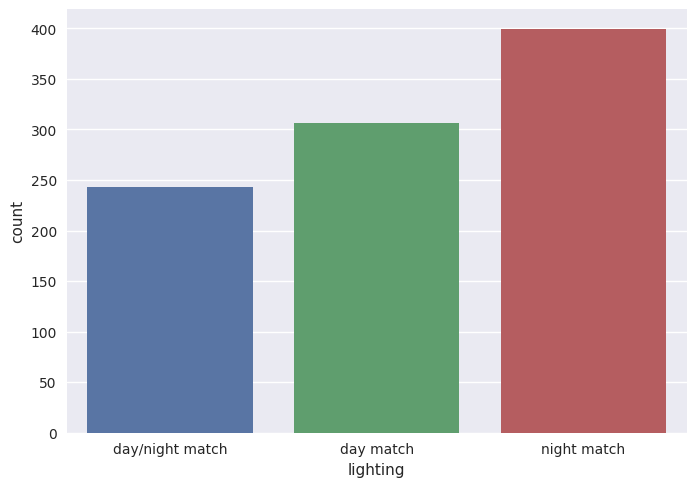

In [55]:
sns.countplot(data = train_data, x = 'lighting' )

We will investigate how the lighting condition favoured the teams. Either it have favoured the batting first team or bowling first team.

In [148]:
def perform_in_lighting(lighting):
    
    df_rel = match_lvl_data[match_lvl_data['lighting'] == lighting] # filtering relevant data
    
    #team with batting first stats in lighting
    df_bat_first = df_rel[df_rel['toss decision'] == 'bat']
    print('batting_first stats in {} condition'.format(lighting) + '\n' ,(pd.Series(df_bat_first['toss winner'] == df_bat_first['winner']).value_counts() / df_bat_first.shape[0]) )
    
    

In [149]:
perform_in_lighting('night match')

batting_first stats in night match condition
 False    0.50655
True     0.49345
Name: count, dtype: float64


In [150]:
perform_in_lighting('day match')

batting_first stats in day match condition
 False    0.541045
True     0.458955
Name: count, dtype: float64


In [151]:
perform_in_lighting('day/night match')

batting_first stats in day/night match condition
 True     0.526718
False    0.473282
Name: count, dtype: float64


> Lets look at the batting first advantage on different ground 

In [15]:
# Ratio of batting first's win % to bowling first win % in the particular ground
def bat_to_bowl_first_winr(ground_id,lighting, date, n = 20):
    '''
    Get a team's win % in last n games. If a team has won 3 game out of their last 5, win% is 60%.
    
    Input-
    1. team_id: ID of the team to get their last n games and winner information from those games.
    2. date: match date from which to get last n historical games.
    3. n: look-back window of games.
    
    Output- None
    
    Returns- Float value denoting win% of the team in last n games.
    '''
    # filter out games with either team1/2_id as input team id, match_dt being before current game's date, sort desc by date, and get top n rows (games)
    df_rel = giveLastGames_ground(ground_id, date, n= 20)
    
    bat_first_win_count = df_rel[(((df_rel['toss decision']== 'bat') & (df_rel['toss winner'] == df_rel['winner']))\
                                | ((df_rel['toss decision']== 'field') & (df_rel['toss winner'] != df_rel['winner'])))\
                                & (df_rel['lighting'] == lighting)].shape[0] # count number of rows having won the match while batting first
    bowl_first_win_count = df_rel.shape[0] - bat_first_win_count

    if bowl_first_win_count == 0:
        return 0
    return round(bat_first_win_count/bowl_first_win_count, 2) # return win% rounded to two decimal points

In [16]:
train_data['bat_to_bowl_winr_first'] = train_data.apply(lambda x: \
                                                                bat_to_bowl_first_winr(x['ground_id'],x['lighting'],x['match_dt']), axis = 1)

In [508]:
test_data['bat_to_bowl_winr_first'] = test_data.apply(lambda x: \
                                                                bat_to_bowl_first_winr(x['ground_id'],x['lighting'],x['match_dt']), axis = 1)

> winning on gound

In [350]:
def win_ground_count(team_name,ground_id, date):
    
    df_rel = giveLastGames_ground(ground_id, date, n= 50)
    df_rel = df_rel[(df_rel['team1'] == team_name) | (df_rel['team2'] == team_name)]
    team_win_count = df_rel[df_rel['winner'] == team_name].shape[0]
    
    return team_win_count
    

In [351]:
train_data['team1_win_ground'] = train_data.apply(lambda x : win_ground_count(x['team1'],x['ground_id'],\
                                                                             x['match_dt']), axis =1)
train_data['team2_win_ground'] = train_data.apply(lambda x : win_ground_count(x['team2'],x['ground_id'],\
                                                                             x['match_dt']), axis =1)

In [352]:
train_data['win_ground_ratio'] = (train_data['team1_win_ground'] +1 )/(train_data['team2_win_ground'] +1)

slope: 0.52 / 0.43 =  1.19


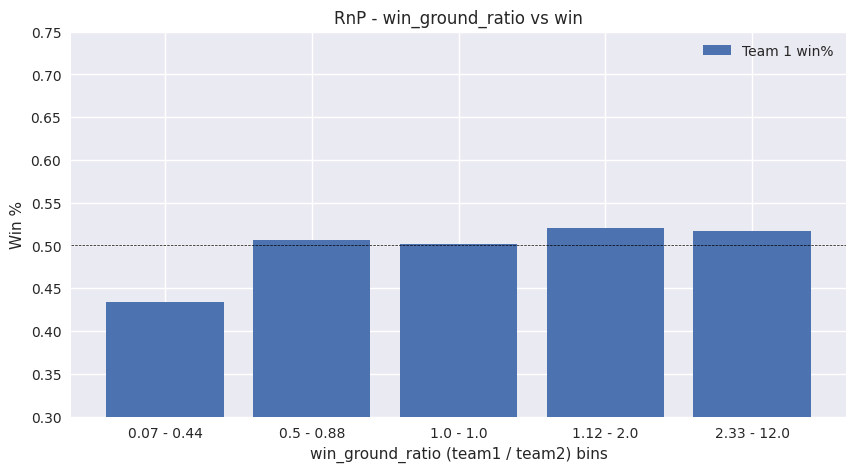

In [353]:
createRnP(train_data, 'win_ground_ratio', ylim_ub=0.75)

> # 2. TEAM level features - Bowlers

> total wickets conceded by team1 and team2 and their ratio **(team1:team2)**

In [301]:
def teamTotalWickets_Lastn(team_id, date, n):
    '''
    Function to calculate a team's total wickets in their last n games.
    
    Input-
    1. team_id: ID of the team to calculate average wickets.
    2. date: match date of the current game for which the feature is calculated.
    3. n: look-back window of games for the team.
    
    Output- None
    
    Return- Integer value denoting the total number of wickets taken by team in their last n games.
    '''
    # filter out games with either team1/2_id as input team_id, match date less than current game's input date, sort desc by date, and top n rows (games) returned
    df_rel = match_lvl_data[(match_lvl_data['match_dt']<date)&\
                      ((match_lvl_data['team1_id']==team_id)|(match_lvl_data['team2_id']==team_id))]\
                        .sort_values(by='match_dt', ascending=False).head(n)
    # combine two dataframes - one where input team is batting first, and another one where input team is batting second.
    df_rel = pd.concat([ df_rel[df_rel['team1_bat_inning']==2][['inning1_wickets']].rename(columns={'inning1_wickets':'wickets'}), \
                         df_rel[df_rel['team1_bat_inning']==1][['inning2_wickets']].rename(columns={'inning2_wickets':'wickets'}) ] )
    return df_rel['wickets'].sum() # return mean of the combined dataframe.


In [325]:
# Compute Total number of wickets taken by team1 in their last 15 games for train data.
train_data['team1only_total_wickets_last15'] = train_data.apply(lambda x: \
                                  teamTotalWickets_Lastn(x['team1_id'], x['match_dt'], 15), axis=1)
# Compute average wickets taken by team1 in their last 15 games for train data.
train_data['team2only_total_wickets_last15'] = train_data.apply(lambda x: \
                                  teamTotalWickets_Lastn(x['team2_id'], x['match_dt'], 15), axis=1)

In [326]:
train_data['team1_to_team2_total_wickets_ratio15'] = (train_data['team1only_total_wickets_last15'] + 1)/(train_data['team2only_total_wickets_last15'] + 1)

#drop intermediate columns
train_data.drop(['team1only_total_wickets_last15', 'team2only_total_wickets_last15'], axis =1, inplace = True)

In [38]:
#similar operation for test dataset
# Compute Total number of wickets taken by team1 in their last 15 games for train data.
test_data['team1only_total_wickets_last15'] = test_data.apply(lambda x: \
                                  teamTotalWickets_Lastn(x['team1_id'], x['match_dt'], 15), axis=1)
# Compute average wickets taken by team1 in their last 15 games for train data.
test_data['team2only_total_wickets_last15'] = test_data.apply(lambda x: \
                                  teamTotalWickets_Lastn(x['team2_id'], x['match_dt'], 15), axis=1)

test_data['team1_to_team2_total_wickets_ratio'] = (test_data['team1only_total_wickets_last15'] + 1)/(test_data['team2only_total_wickets_last15'] + 1)

#drop intermediate columns
test_data.drop(['team1only_total_wickets_last15', 'team2only_total_wickets_last15'], axis =1, inplace = True)

slope: 0.55 / 0.44 =  1.25


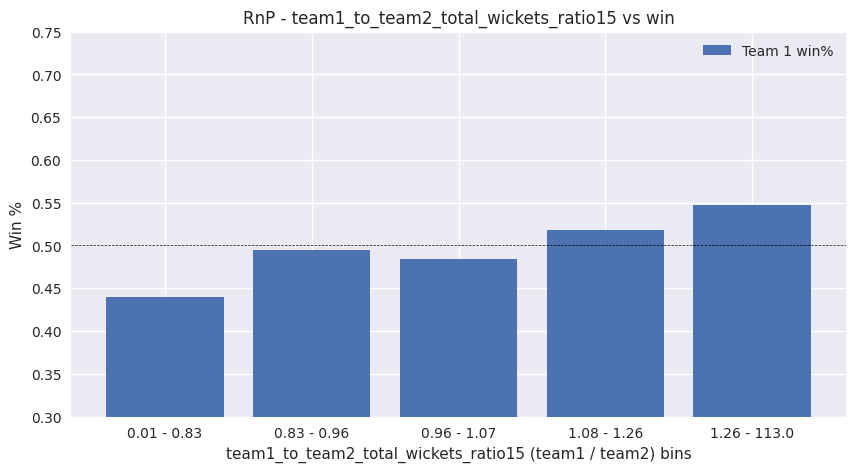

In [327]:
createRnP(train_data, 'team1_to_team2_total_wickets_ratio15', ylim_ub=0.75)

team1_to_team2_total_wickets_ratio feature shows promising results

> more than k wickets

In [269]:

def more_than_k_wickets_Lastn(player_list, date, n, k):
    '''
    Function to get total number of times players in team took more than k wickets last n games.
    
    Input-
    1. player_list: ':' separated list of player ids in the roster of a team.
    2. date: match date of the game to calculate this feature.
    3. n: Number of games to look-back and create this feature.
    4. k: integer - representing wickets 
    
    Output-None
    
    Returns- total number of times players in team took more than k wickets last n games.
    '''
    
    player_list = str(player_list).split(':') # split string of ':' separated ids into a list of ids
    res_list = []
    for player in player_list: # loop over each player_id in roster
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bowl') # getting batting stats from last n games for each player.
        df_rel['gte_k_wickets'] = np.where(df_rel['wicket_count']>=k, 1, 0) # binary indicator to denote whether the player scored a 50 in the game (runs>=50).
        res_list.append(np.nansum(df_rel['gte_k_wickets']))# Sum up number of 50s for the player and append to a list. We will do this for all players.
    return np.nansum(res_list)# Sum up values of the list which is sum of 50s by all players in the roster.



In [270]:
# Computing number of 50 runs in last 15 games for team1 for train dataset.
k = 2
train_data['team1_count_{}_wickets_last15'.format(k)] = train_data.apply(lambda x: \
            more_than_k_wickets_Lastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15 , k=2), axis=1)
# Computing number of 50 runs in last 15 games for team2 for train dataset.
train_data['team2_count_{}_wickets_last15'.format(k)] = train_data.apply(lambda x: \
           more_than_k_wickets_Lastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15, k=2), axis=1)


# Taking ratio of (number of 50 runs in last 15 games for team1) to (number of 50 runs in last 15 games for team2). Adding 1 to handle divide by zero exceptions.
train_data['team_ratio_{}_wickets_last15'.format(k)] = (train_data['team1_count_{}_wickets_last15'.format(k)]+1)/(train_data['team2_count_{}_wickets_last15'.format(k)]+1)
train_data.drop(columns=['team1_count_{}_wickets_last15'.format(k),'team2_count_{}_wickets_last15'.format(k)], inplace=True) # dropping intermediate columns

I tried for k = 2,3,4,5 

slope: 0.59 / 0.41 =  1.46


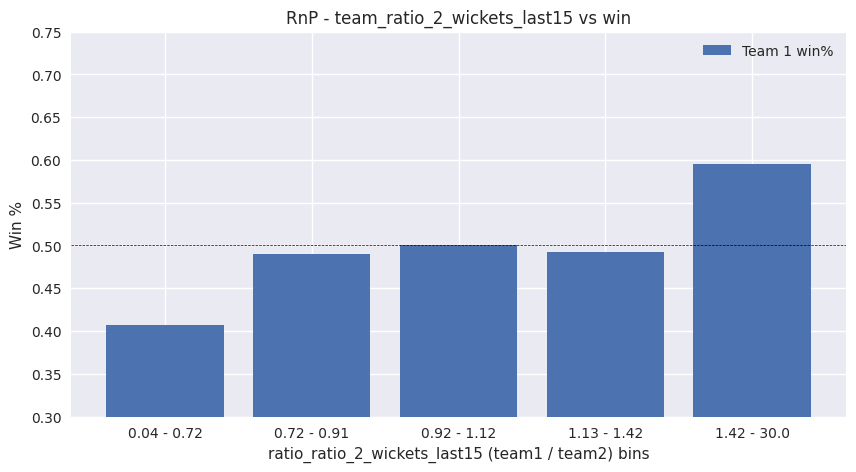

In [271]:
createRnP(train_data, 'team_ratio_2_wickets_last15', ylim_ub=0.75)

slope: 0.56 / 0.44 =  1.27


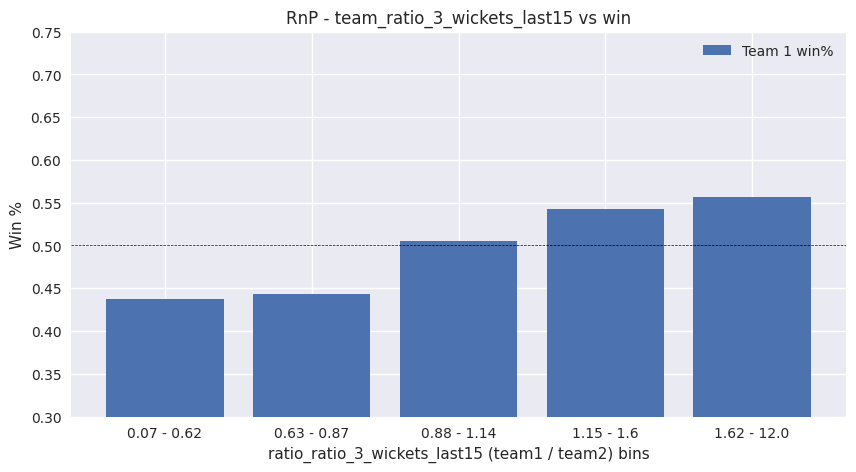

In [43]:
createRnP(train_data, 'team_ratio_3_wickets_last15', ylim_ub=0.75)

slope: 0.53 / 0.51 =  1.04


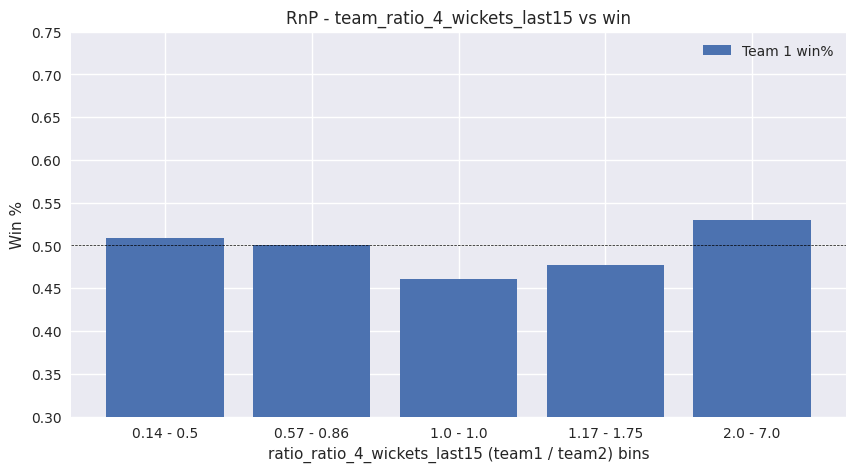

In [58]:
createRnP(train_data, 'team_ratio_4_wickets_last15', ylim_ub=0.75)

slope: 0.54 / 0.52 =  1.03


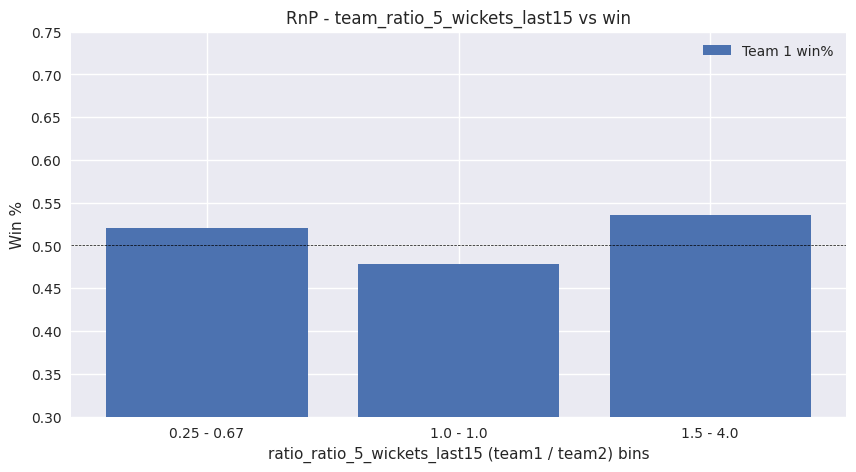

In [70]:
createRnP(train_data, 'team_ratio_5_wickets_last15', ylim_ub=0.75)

In [44]:
#similar process for test data
# Computing number of 50 runs in last 15 games for team1 for train dataset.
k = 3
test_data['team1_count_{}_wickets_last15'.format(k)] = test_data.apply(lambda x: \
            more_than_k_wickets_Lastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15 , k=3), axis=1)
# Computing number of 50 runs in last 15 games for team2 for train dataset.
test_data['team2_count_{}_wickets_last15'.format(k)] = test_data.apply(lambda x: \
           more_than_k_wickets_Lastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15, k=3), axis=1)


# Taking ratio of (number of 50 runs in last 15 games for team1) to (number of 50 runs in last 15 games for team2). Adding 1 to handle divide by zero exceptions.
test_data['team_ratio_{}_wickets_last15'.format(k)] = (test_data['team1_count_{}_wickets_last15'.format(k)]+1)/(test_data['team2_count_{}_wickets_last15'.format(k)]+1)
test_data.drop(columns=['team1_count_{}_wickets_last15'.format(k),'team2_count_{}_wickets_last15'.format(k)], inplace=True) # dropping intermediate columns

> dot balls 

In [208]:
# function to calculate total number of dot balls conceded by a team in last n matches

def total_dot_balls_lastn(player_list, date, n):
    '''
    Function to get total number of dot balls conceded by players in the roster of a team in last n games.
    
    Input-
    1. player_list: ':' separated list of player ids in the roster of a team.
    2. date: match date of the game to calculate this feature.
    3. n: Number of games to look-back and create this feature.
    
    Output-None
    
    Returns- int value total number of dot balls by all players in the roster.
    '''
    player_list = str(player_list).split(':') # split string of ':' separated ids into a list of ids
    res_list = []
    for player in player_list: # loop over each player_id in roster
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bowl') # getting bowling stats from last n games for each player.
        res_list.append(np.nansum(df_rel['dots']))# Sum up number of dot balls for the player and append to a list. We will do this for all players.
    return np.nansum(res_list)# Sum up all values to get dot balls conceded by team

In [46]:
#computing total number of dot balls conceded by team1
train_data['total_dot_team1_last15'] = train_data.apply(lambda x: \
            total_dot_balls_lastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

#computing total number of dot balls conceded by team2
train_data['total_dot_team2_last15'] = train_data.apply(lambda x: \
            total_dot_balls_lastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)


# Taking ratio of (total number of dot balls conceded by team1) to (total number of dot balls conceded by team1). Adding 1 to handle divide by zero exceptions.
train_data['total_dot_ratio_last15'] = (train_data['total_dot_team1_last15']+1)/(train_data['total_dot_team2_last15']+1)
train_data.drop(columns=['total_dot_team1_last15','total_dot_team2_last15'], inplace=True) # dropping intermediate columns

slope: 0.56 / 0.34 =  1.64


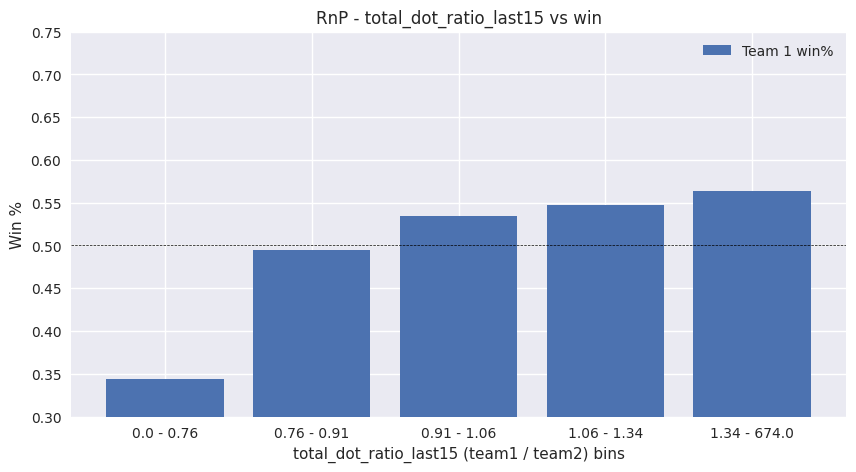

In [47]:
createRnP(train_data, 'total_dot_ratio_last15', ylim_ub=0.75)

total_dot_ratio_last15 shows promising results as the ratio of total dot balls conceded by team1 increases the chances of winning also increases for team1.

In [48]:
#similar process for test data
#computing total number of dot balls conceded by team1
test_data['total_dot_team1_last15'] = test_data.apply(lambda x: \
            total_dot_balls_lastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

#computing total number of dot balls conceded by team2
test_data['total_dot_team2_last15'] = test_data.apply(lambda x: \
            total_dot_balls_lastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)


# Taking ratio of (total number of dot balls conceded by team1) to (total number of dot balls conceded by team1). Adding 1 to handle divide by zero exceptions.
test_data['total_dot_ratio_last15'] = (test_data['total_dot_team1_last15']+1)/(test_data['total_dot_team2_last15']+1)
test_data.drop(columns=['total_dot_team1_last15','total_dot_team2_last15'], inplace=True) # dropping intermediate columns

> # 3. Strength of opposition - Aggregate Team level 

> This is the batting/bowling strength of the opposition team. It is the
average of the consistency measure of the batsmen/bowlers of the opposition team.Players find it easy to score runs/take wickets against weaker teams than stronger teams.

Research paper link - [here](http://arxiv.org/pdf/1804.04226)

**Consistency:** This aspect of the player’s game demonstrates how consistent the player has been in his entire career.

• **Batting Consistency** = 0.4262*average + 0.2566*no. of innings + 0.1510*SR +
0.0787*Centuries + 0.0556*Fifties – 0.0328*Ducks

> Batting Strength

In [8]:
# helper function to calculate each of the attributes required to calculate batting consistency

def strengthOfOpposition_batting(player_list, date, n =15):
    '''
    Function to calculate the batting strength of the team.
    Input-
    1. player_list: ':' separated list of player ids in the roster of a team.
    2. date: match date of the game to calculate this feature.
    3. n: Number of games to look-back and create this feature.
    
    Output-None
    
    Returns- int value representing the batting strength of the team.
    '''
    player_list = str(player_list).split(':') # split string of ':' separated ids into a list of ids
    consistency = []
    for player_id in player_list:
        #getting last n games of the player
        df_rel = giveLastNgamesPlayer(player_id, date, n, bat_or_bowl = 'bat')
        #calculating avg runs, no. of innings, strike rate, number of 100's,50's and 0's runs
        avg_runs = np.nansum(df_rel['runs']) / (df_rel.shape[0] +1)
        no_of_innings = df_rel.shape[0]
        SR = (np.nansum(df_rel['runs']) / (np.nansum(df_rel['balls_faced']) + 1)) * 100
        centuries = df_rel[df_rel['runs'] >= 100].shape[0]
        fifties = df_rel[df_rel['runs'] >= 50].shape[0]
        ducks = df_rel[df_rel['runs'] == 0].shape[0]
        
        #calculating batting conistency of the player
        batting_consistency = (0.4262 * avg_runs) + (0.2566 * no_of_innings) + \
        (0.1510 * SR) + (0.0787 * centuries) + (0.0556 * fifties) - (0.0328 * ducks)
        
        consistency.append(batting_consistency)
    return np.nansum(consistency) 
    

In [9]:
#calculating batting strength for team1
train_data['strength_team1_batting'] = train_data.apply(lambda x: \
            strengthOfOpposition_batting(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

#calculating batting strength for team1
train_data['strength_team2_batting'] = train_data.apply(lambda x: \
            strengthOfOpposition_batting(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

#batting strength ratio team1 : team2
train_data['batting_strength_ratio'] = (train_data['strength_team1_batting'] )/(train_data['strength_team2_batting'] )

#dropping the intermediate columns
train_data.drop(['strength_team1_batting','strength_team2_batting'], axis = 1, inplace = True)

slope: 0.56 / 0.4 =  1.4


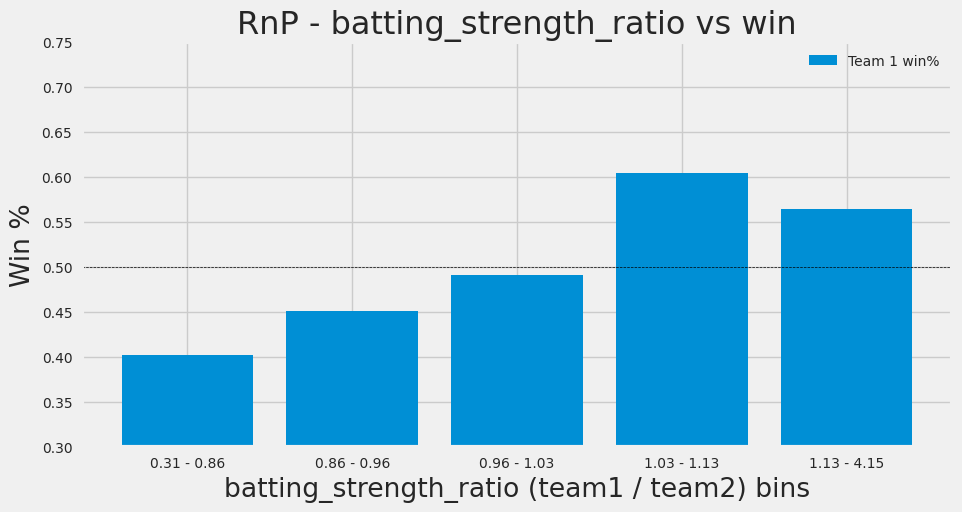

In [156]:
createRnP(train_data, 'batting_strength_ratio', ylim_ub=0.75)

Eureka! we got some good feature here

In [209]:
#similar process for test data
#calculating batting strength for team1
test_data['strength_team1_batting'] = test_data.apply(lambda x: \
            strengthOfOpposition_batting(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

#calculating batting strength for team1
test_data['strength_team2_batting'] = test_data.apply(lambda x: \
            strengthOfOpposition_batting(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

#batting strength ratio team1 : team2
test_data['batting_strength_ratio'] = (test_data['strength_team1_batting'])/(test_data['strength_team2_batting'] + 1)

#dropping the intermediate columns
test_data.drop(['strength_team1_batting','strength_team2_batting'], axis = 1, inplace = True)

> Bowling strength


• **Bowling Consistency**= 0.4174*no. of overs + 0.2634*no. of innings + 0.1602*SR + 0.0975*average + 0.0615*five wicket haul

In [158]:
# helper function to calculate each of the attributes required to calculate batting consistency

def strengthOfOpposition_bowling(player_list, date, n =15):
    '''
    Function to calculate the bowling strength of the team.
    Input-
    1. player_list: ':' separated list of player ids in the roster of a team.
    2. date: match date of the game to calculate this feature.
    3. n: Number of games to look-back and create this feature.
    
    Output-None
    
    Returns- int value representing the batting strength of the team.
    '''
    player_list = str(player_list).split(':') # split string of ':' separated ids into a list of ids
    consistency = []
    for player_id in player_list:
        #getting last n games of the player
        df_rel = giveLastNgamesPlayer(player_id, date, n, bat_or_bowl = 'bowl')
        #calculating avg runs, no. of innings, strike rate, number of 100's,50's and 0's runs
        no_of_overs = np.nansum(df_rel['balls_bowled']) // 6
        no_of_innings = df_rel.shape[0]
        SR = (np.nansum(df_rel['balls_bowled']) / (np.nansum(df_rel['wicket_count']) + 1)) 
        average = (np.nansum(df_rel['runs'])) / (np.nansum(df_rel['wicket_count']) + 1)
        five_wickets = df_rel[df_rel['wicket_count'] >= 5].shape[0] 
        
        #calculating batting conistency of the player
        bowling_consistency = (0.4174 * no_of_overs) + (0.2634 * no_of_innings) + \
        (0.1602 * SR )+ (0.0975 * average) + (0.0615 * five_wickets)
        
        consistency.append(bowling_consistency)
    return np.nansum(consistency) 
    

In [159]:
#calculating batting strength for team1
train_data['strength_team1_bowling'] = train_data.apply(lambda x: \
            strengthOfOpposition_bowling(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

#calculating batting strength for team1
train_data['strength_team2_bowling'] = train_data.apply(lambda x: \
            strengthOfOpposition_bowling(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

#batting strength ratio team1 : team2
train_data['bowling_strength_ratio'] = (train_data['strength_team1_bowling'])/(train_data['strength_team2_bowling'])

#dropping the intermediate columns
train_data.drop(['strength_team1_bowling','strength_team2_bowling'], axis = 1, inplace = True)

slope: 0.55 / 0.38 =  1.42


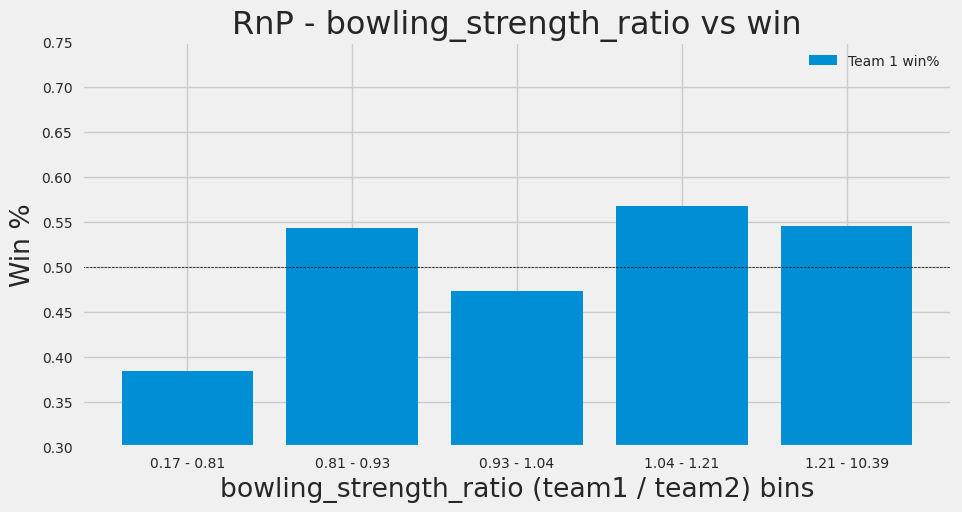

In [160]:
createRnP(train_data, 'bowling_strength_ratio', ylim_ub=0.75)

Not as good as the batting strength but we can see the upward trend in general

In [206]:
#similar process for Test Data
#calculating batting strength for team1
test_data['strength_team1_bowling'] = test_data.apply(lambda x: \
            strengthOfOpposition_bowling(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

#calculating batting strength for team1
test_data['strength_team2_bowling'] = test_data.apply(lambda x: \
            strengthOfOpposition_bowling(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

#batting strength ratio team1 : team2
test_data['bowling_strength_ratio'] = (test_data['strength_team1_bowling'] + 1)/(test_data['strength_team2_bowling'] + 1)

#dropping the intermediate columns
test_data.drop(['strength_team1_bowling','strength_team2_bowling'], axis = 1, inplace = True)

> # 4. Toss Influence 

In [6]:
train_data['toss decision'].value_counts()

toss decision
field    617
bat      331
Name: count, dtype: int64

clearly we see that teams have the preference to field first. As a cricket lover country we already know this by intuition that factors like dew plays a important role here. But let's prove this intuition by data.

dew plays an important role in evening or night matches. It is hard for the batting first team to field second because of the dew. Bowlers loses their grip. Inverserly, this will increase the performance of the batsman of opposition team.

In [9]:
train_data[train_data['toss decision'] == 'field']['lighting'].value_counts(normalize = True)

lighting
night match        0.461912
day match          0.293355
day/night match    0.244733
Name: proportion, dtype: float64

we were right! About 70% of the field first decision were taken in matches that were played either in night or day/night condition.

In [41]:
train_data[train_data['lighting'] != 'day match']['toss decision'].value_counts(normalize = True)

toss decision
field    0.679128
bat      0.320872
Name: proportion, dtype: float64

similary out of all the matches played in night, 67% of the times team choosed to field first if they won the toss.

*How many times the field first team won given that the team won the toss?*

In [39]:
train_data[((train_data['toss winner'] == train_data['winner']) & (train_data['toss decision'] == 'field')) 
          ]['toss decision'].shape[0] / 617

0.49108589951377635

Clearly, we can see there is no proof that the field first team 

In [19]:
train_data[((train_data['toss winner'] == train_data['winner']) & (train_data['toss decision'] == 'field')) |\
           ((train_data['toss winner'] != train_data['winner']) & (train_data['toss decision'] == 'bat'))
          ]['toss decision'].value_counts(normalize = True)

toss decision
field    0.63522
bat      0.36478
Name: proportion, dtype: float64

Toss_to_Win_Conversion_Rate

In [210]:
def toss_win_conversion(team_name, date, n = 20):
    
    #getting the relevant data
    df_rel = match_lvl_data[(match_lvl_data['match_dt'] < date)] # getting matches before the given date
    
    toss_winonly_data = df_rel[df_rel['toss winner'] == team_name].\
                    sort_values(by='match_dt', ascending=False).head(n)
    toss_winonly_count = toss_winonly_data.shape[0]
    toss_win_count = toss_winonly_data[toss_winonly_data['toss winner'] == toss_winonly_data['winner']].shape[0] 
    
    if toss_winonly_count == 0:
        return 0
    return round(toss_win_count/toss_winonly_count, 2)

In [10]:
train_data['team1_toss_win_conversion'] = train_data.apply(lambda x : \
                                                          toss_win_conversion(x['team1'],\
                                                                             x['match_dt']), axis = 1)
train_data['team2_toss_win_conversion'] = train_data.apply(lambda x : \
                                                          toss_win_conversion(x['team2'],\
                                                                             x['match_dt']), axis = 1)

In [15]:
train_data['toss_win_conv_ratio'] = (train_data['team1_toss_win_conversion'] +1 )/(train_data['team2_toss_win_conversion'] + 1)

In [211]:
test_data['team1_toss_win_conversion'] = test_data.apply(lambda x : \
                                                          toss_win_conversion(x['team1'],\
                                                                             x['match_dt']), axis = 1)
test_data['team2_toss_win_conversion'] = test_data.apply(lambda x : \
                                                          toss_win_conversion(x['team2'],\
                                                                             x['match_dt']), axis = 1)
test_data['toss_win_conv_ratio'] = (test_data['team1_toss_win_conversion'] +1 )/(test_data['team2_toss_win_conversion'] + 1)

slope: 0.56 / 0.4 =  1.39


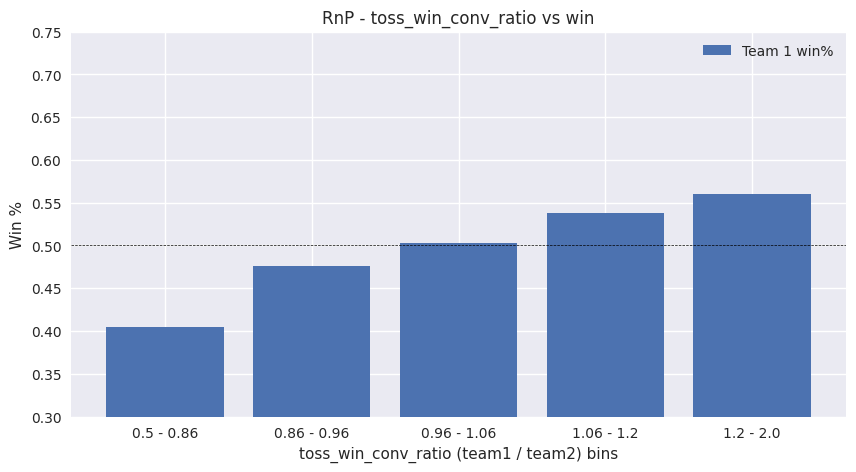

In [30]:
createRnP(train_data, 'toss_win_conv_ratio', N= 5,ylim_ub=0.75)

> # 5. Team level - Batting

In [10]:
def boundaries(player_ids, date, N=5):
    
    player_list = str(player_ids).split(':') # split string of ':' separated ids into a list of ids
    res_list = []
    for player in player_list: # loop over each player_id in roster
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=N, bat_or_bowl='bat') # getting batting stats from last n games for each player.
        four_counts = np.nansum(df_rel['Fours']) # binary indicator to denote whether the player scored a 50 in the game (runs>=50).
        six_counts = np.nansum(df_rel['Sixes']) 
        boundaries = four_counts + six_counts
        res_list.append(boundaries)# Sum up number of 50s for the player and append to a list. We will do this for all players.
    return np.nansum(res_list)# Sum up values of the list which is sum of 50s by all players in the roster.

    

In [11]:
train_data['team1_boundaries_last15'] = train_data.apply(lambda x : boundaries(x['team1_roster_ids'],
                                                                              x['match_dt']), axis = 1)
train_data['team2_boundaries_last15'] = train_data.apply(lambda x : boundaries(x['team2_roster_ids'],
                                                                              x['match_dt']), axis = 1)

In [29]:
train_data['boundaries_last15'] = (train_data['team1_boundaries_last15'] )/(train_data['team2_boundaries_last15'] + 1)

slope: 0.57 / 0.41 =  1.4


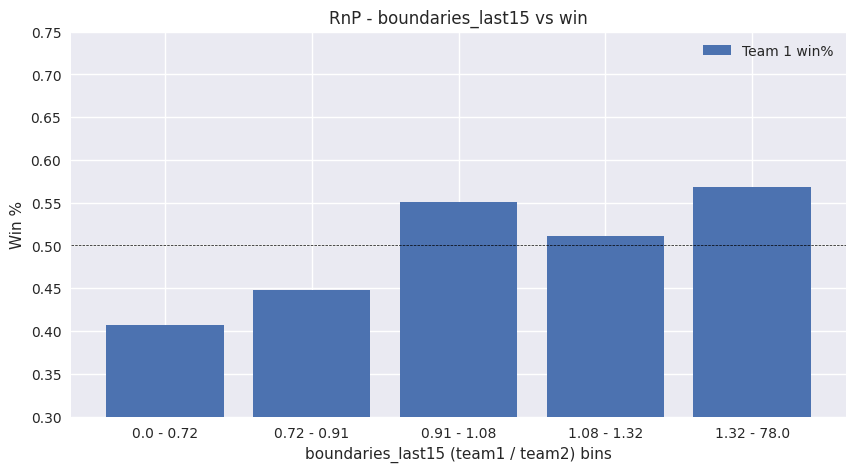

In [30]:
createRnP(train_data, 'boundaries_last15', N= 5 ,ylim_ub=0.75)

slope: 0.59 / 0.41 =  1.44


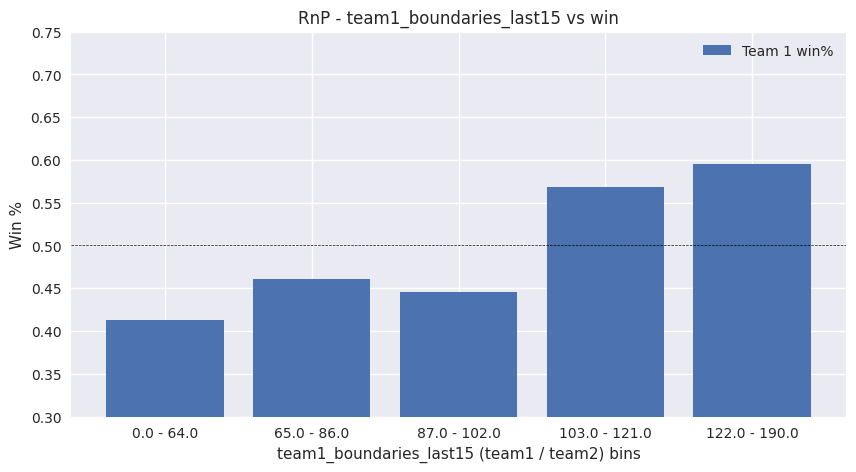

In [21]:
createRnP(train_data, 'team1_boundaries_last15', N= 5 ,ylim_ub=0.75)

In [13]:
#similar for test data
test_data['team1_boundaries_last15'] = test_data.apply(lambda x : boundaries(x['team1_roster_ids'],
                                                                              x['match_dt']), axis = 1)
test_data['team2_boundaries_last15'] = test_data.apply(lambda x : boundaries(x['team2_roster_ids'],
                                                                              x['match_dt']), axis = 1)

In [ ]:
#ball faced by the batsman of team1

def ball_faces (teamid, date, N= 15)

# Saving the Features

In [342]:
#saving files with calculated features
train_data.to_csv('train_with_features.csv', index = False)
test_data.to_csv('test_with_features.csv', index = False)

In [8]:
#loading the files
train_data = pd.read_csv('/kaggle/input/american-express-with-features/train_with_features.csv')
test_data = pd.read_csv('/kaggle/input/american-express-with-features/test_with_features.csv')

In [9]:
#loading the files with binned data
train_data_binned = pd.read_csv('/kaggle/input/american-express-with-features/train_data_binned.csv')

In [14]:
def batting_strength_team(player_list, date, n= 10):
    
    '''
    Function to calculate the batting strength of the team.
    Input-
    1. player_list: ':' separated list of player ids in the roster of a team.
    2. date: match date of the game to calculate this feature.
    3. n: Number of games to look-back and create this feature.
    
    Output-None
    
    Returns- int value representing the batting strength of the team.
    '''
    player_list = str(player_list).split(':') # split string of ':' separated ids into a list of ids
    sr_player= []
    avg_run_player = []
    for player_id in player_list:
        #getting last n games of the player
        df_rel = giveLastNgamesPlayer(player_id, date, n, bat_or_bowl = 'bat')
        #calculating avg runs, no. of innings, strike rate, number of 100's,50's and 0's runs
        avg_runs = np.nansum(df_rel['runs']) / (df_rel.shape[0] +1)
        SR = (np.nansum(df_rel['runs']) / (np.nansum(df_rel['balls_faced']) + 1)) * 100
        
        avg_run_player.append(avg_runs)
        sr_player.append(SR)
        
    
    avg_SR = np.nansum(sr_player) / len(sr_player)
    avg_runs = np.nansum(avg_run_player) / len(avg_run_player)
    
    bat_strength = (0.40 * avg_runs) + (0.60 * avg_SR)
    
    return bat_strength

In [15]:
#calculating batting strength for team1
train_data['strength_team1_batting'] = train_data.apply(lambda x: \
            batting_strength_team(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

#calculating batting strength for team1
train_data['strength_team2_batting'] = train_data.apply(lambda x: \
            batting_strength_team(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)


In [24]:
train_data['bat_ratio'] = (train_data['strength_team1_batting'] + 1)/(train_data['strength_team2_batting'] +1 )

slope: 0.56 / 0.42 =  1.32


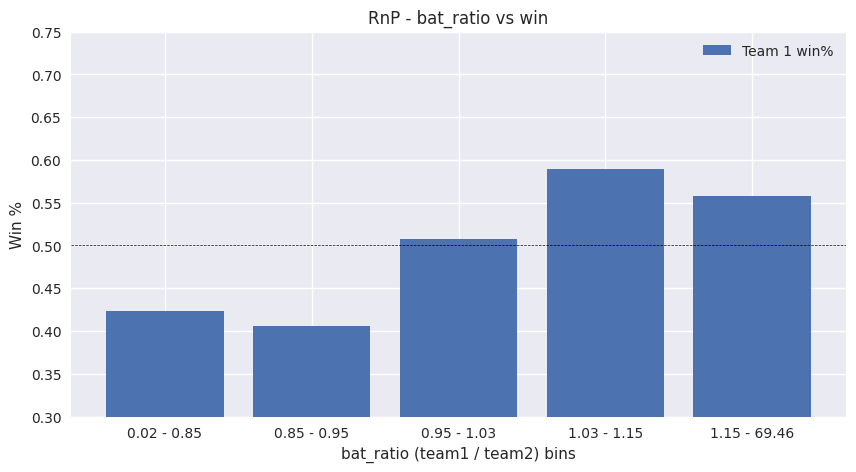

In [25]:
createRnP(train_data, 'bat_ratio', N= 5 ,ylim_ub=0.75)

In [93]:
#calculating batting strength for team1
test_data['strength_team1_batting'] = test_data.apply(lambda x: \
            batting_strength_team(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

#calculating batting strength for team1
test_data['strength_team2_batting'] = test_data.apply(lambda x: \
            batting_strength_team(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data['bat_ratio'] = (test_data['strength_team1_batting'] + 1)/(test_data['strength_team2_batting'] +1 )

# Feature Selection

In [26]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from xgboost import plot_importance
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier

In [27]:
train_data_binned.columns

Index(['Unnamed: 0', 'match id', 'team1', 'team1_id', 'team1_roster_ids',
       'team2', 'team2_id', 'team2_roster_ids', 'winner', 'winner_id',
       'toss winner', 'toss decision', 'venue', 'city', 'match_dt', 'lighting',
       'series_name', 'season', 'ground_id', 'winner_01', 'toss_winner_01',
       'toss_decision_01', 'team_count_50runs_last15_binned',
       'team_winp_last5_binned', 'team1only_avg_runs_last15_binned',
       'team1_winp_team2_last15_binned', 'ground_avg_runs_last15_binned',
       'ground_avg_wickets_last15_binned', 'inning_runs_ratio_binned',
       'succ_chase_r_ground_last_15_binned', 'bat_to_bowl_winr_first_binned',
       'team1_to_team2_total_wickets_ratio_binned',
       'team_ratio_3_wickets_last15_binned', 'total_dot_ratio_last15_binned',
       'batting_strength_ratio_binned', 'bowling_strength_ratio_binned',
       'team1_toss_win_conversion_binned', 'team2_toss_win_conversion_binned',
       'toss_win_conv_ratio_binned'],
      dtype='object')

In [12]:
features_with_target = ['toss_winner_01','winner_01',
       'toss_decision_01', 'team_count_50runs_last15_binned',
       'team_winp_last5_binned', 'team1only_avg_runs_last15_binned',
       'team1_winp_team2_last15_binned', 'ground_avg_runs_last15_binned',
       'ground_avg_wickets_last15_binned', 'inning_runs_ratio_binned',
       'succ_chase_r_ground_last_15_binned', 'bat_to_bowl_winr_first_binned',
       'team1_to_team2_total_wickets_ratio_binned',
       'team_ratio_3_wickets_last15_binned', 'total_dot_ratio_last15_binned',
       'batting_strength_ratio_binned', 'bowling_strength_ratio_binned',
       'team1_toss_win_conversion_binned', 'team2_toss_win_conversion_binned',
       'toss_win_conv_ratio_binned']

In [345]:
train_data_binned[features_with_target].isnull().sum()

toss_winner_01                                0
winner_01                                     0
toss_decision_01                              0
team_count_50runs_last15_binned               0
team_winp_last5_binned                        0
team1only_avg_runs_last15_binned             21
team1_winp_team2_last15_binned                0
ground_avg_runs_last15_binned                53
ground_avg_wickets_last15_binned             53
inning_runs_ratio_binned                     53
succ_chase_r_ground_last_15_binned            0
bat_to_bowl_winr_first_binned                 0
team1_to_team2_total_wickets_ratio_binned     0
team_ratio_3_wickets_last15_binned            0
total_dot_ratio_last15_binned                 0
batting_strength_ratio_binned                 0
bowling_strength_ratio_binned                 0
team1_toss_win_conversion_binned              0
team2_toss_win_conversion_binned              0
toss_win_conv_ratio_binned                    0
dtype: int64

> Correlation

In [346]:
train_data_binned[features_with_target].corr()

,toss_winner_01,winner_01,toss_decision_01,team_count_50runs_last15_binned,team_winp_last5_binned,team1only_avg_runs_last15_binned,team1_winp_team2_last15_binned,ground_avg_runs_last15_binned,ground_avg_wickets_last15_binned,inning_runs_ratio_binned,succ_chase_r_ground_last_15_binned,bat_to_bowl_winr_first_binned,team1_to_team2_total_wickets_ratio_binned,team_ratio_3_wickets_last15_binned,total_dot_ratio_last15_binned,batting_strength_ratio_binned,bowling_strength_ratio_binned,team1_toss_win_conversion_binned,team2_toss_win_conversion_binned,toss_win_conv_ratio_binned
toss_winner_01,1.000000,-0.039748,-0.993047,0.022453,-0.034819,-0.053080,0.001455,0.088592,-0.078169,-0.106425,0.113485,-0.115602,-0.014651,0.032158,0.023508,-0.020374,0.023508,0.021502,0.051302,-0.019621
winner_01,-0.039748,1.000000,0.032983,-0.154912,-0.124538,-0.028244,-0.046719,-0.024530,0.017339,0.049928,-0.060335,0.013400,-0.066364,-0.097683,-0.138666,-0.147612,-0.123756,-0.098614,0.033542,-0.104826
toss_decision_01,-0.993047,0.032983,1.000000,-0.022380,0.032715,0.059392,-0.006002,-0.081758,0.079720,0.106306,-0.114442,0.108712,0.017753,-0.035155,-0.026586,0.015639,-0.023458,-0.022357,-0.051119,0.019629
team_count_50runs_last15_binned,0.022453,-0.154912,-0.022380,1.000000,0.246744,0.129435,0.084714,0.036118,-0.001369,-0.018873,-0.037424,0.059087,0.173545,0.101611,0.075114,0.503578,0.076700,0.106274,-0.101898,0.172181
team_winp_last5_binned,-0.034819,-0.124538,0.032715,0.246744,1.000000,0.060585,0.223673,0.042430,0.000629,-0.004828,-0.013244,-0.019143,0.095946,0.175532,0.181121,0.240624,0.136754,0.279439,-0.262697,0.396866
team1only_avg_runs_last15_binned,-0.053080,-0.028244,0.059392,0.129435,0.060585,1.000000,0.117603,0.297893,0.056978,-0.046851,-0.020230,-0.014706,0.083934,-0.016216,-0.003204,0.126329,0.027627,-0.029914,0.063495,-0.076039
team1_winp_team2_last15_binned,0.001455,-0.046719,-0.006002,0.084714,0.223673,0.117603,1.000000,0.098131,0.034279,-0.020109,0.010379,0.051031,0.015708,0.069425,0.061856,0.108085,0.052089,0.198379,-0.116429,0.242188
ground_avg_runs_last15_binned,0.088592,-0.024530,-0.081758,0.036118,0.042430,0.297893,0.098131,1.000000,-0.050936,-0.157620,-0.100470,0.032676,-0.059983,-0.055106,-0.048975,-0.029978,-0.042740,-0.007722,0.011720,-0.027024
ground_avg_wickets_last15_binned,-0.078169,0.017339,0.079720,-0.001369,0.000629,0.056978,0.034279,-0.050936,1.000000,0.417860,-0.470576,0.129307,0.049774,-0.054063,-0.004050,0.006618,0.009461,-0.039436,-0.077024,0.023381
inning_runs_ratio_binned,-0.106425,0.049928,0.106306,-0.018873,-0.004828,-0.046851,-0.020109,-0.157620,0.417860,1.000000,-0.568512,0.225827,0.045267,-0.026340,0.010932,0.012577,0.013736,-0.106939,-0.119502,0.030203


<Axes: >

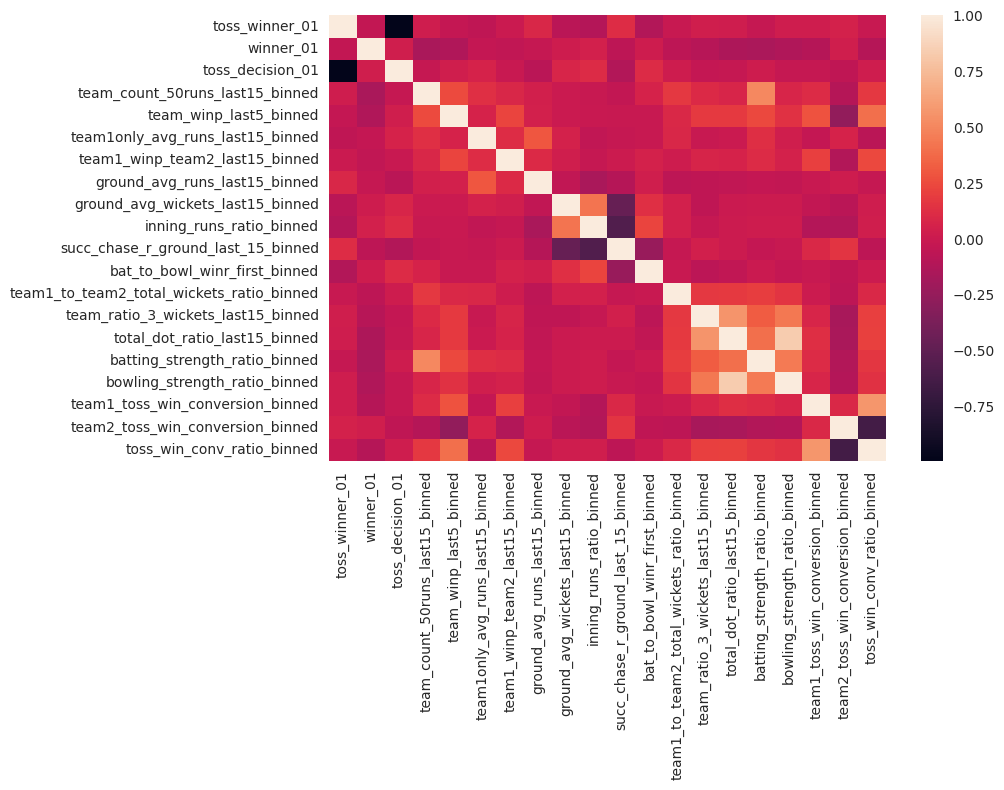

In [347]:
sns.heatmap(train_data_binned[features_with_target].corr())

In [13]:
train_data_binned[features_with_target].corr()['winner_01']

toss_winner_01                              -0.039748
winner_01                                    1.000000
toss_decision_01                             0.032983
team_count_50runs_last15_binned             -0.154912
team_winp_last5_binned                      -0.124538
team1only_avg_runs_last15_binned            -0.028244
team1_winp_team2_last15_binned              -0.046719
ground_avg_runs_last15_binned               -0.024530
ground_avg_wickets_last15_binned             0.017339
inning_runs_ratio_binned                     0.049928
succ_chase_r_ground_last_15_binned          -0.060335
bat_to_bowl_winr_first_binned                0.013400
team1_to_team2_total_wickets_ratio_binned   -0.066364
team_ratio_3_wickets_last15_binned          -0.097683
total_dot_ratio_last15_binned               -0.138666
batting_strength_ratio_binned               -0.147612
bowling_strength_ratio_binned               -0.123756
team1_toss_win_conversion_binned            -0.098614
team2_toss_win_conversion_bi

In [199]:
features = ['toss_winner_01',
       'toss_decision_01', 'team_count_50runs_last15_binned',
       'team_winp_last5_binned', 'team1only_avg_runs_last15_binned',
       'team1_winp_team2_last15_binned', 'ground_avg_runs_last15_binned',
       'ground_avg_wickets_last15_binned', 'inning_runs_ratio_binned',
       'succ_chase_r_ground_last_15_binned', 'bat_to_bowl_winr_first_binned',
       'team1_to_team2_total_wickets_ratio_binned','city',
       'team_ratio_3_wickets_last15_binned', 'total_dot_ratio_last15_binned',
       'batting_strength_ratio_binned', 'bowling_strength_ratio_binned',
       'team1_toss_win_conversion_binned', 'team2_toss_win_conversion_binned',
       'toss_win_conv_ratio_binned','team1_boundaries_last15']

we will divide the above features into 5 different categories, depending on what it represents or convey. we will train an independent model on each of these categories and then choose the majority outcome.

In [188]:
train_data_binned['team1_boundaries_last15'] = train_data['team1_boundaries_last15']
train_data_binned['city'] = train_data['city']


In [190]:
train_data_binned['city'] = train_data_binned['city'].astype('category')

In [212]:
    
batting_features = ['batting_strength_ratio_binned',
                   'team_count_50runs_last15_binned',
                   'team1only_avg_runs_last15_binned',]

bowling_features = ['total_dot_ratio_last15_binned',
                   'bowling_strength_ratio_binned','team_ratio_3_wickets_last15_binned',]

external_features = [
                    'toss_win_conv_ratio_binned','toss_decision_01',
                'team_winp_last5_binned','city',
                    'toss_winner_01','ground_avg_runs_last15_binned',
       'ground_avg_wickets_last15_binned', ]


In [254]:
train_data_binned['venue'] = train_data_binned['venue'].astype('category')

In [192]:
feature_dict = {'batting_feature' : batting_features, 'bowling_feature': bowling_features,
               'external_feature' : external_features}

In [193]:
for key in feature_dict.keys():
    print (key)

batting_feature
bowling_feature
external_feature


In [194]:
from sklearn.model_selection import GridSearchCV

def best_parameters(features_dict):
    
    for key in features_dict.keys():
        clf =XGBClassifier(enable_categorical = True)
        param_grid = {"max_depth":    [2,3,4,5,6],
                      "n_estimators": [100,200,500,1000],
                      "learning_rate": [0.001, 0.01, 0.1]}
        X,y = train_data_binned[features_dict[key]], train_data_binned['winner_01']
        # try out every combination of the above values
        search = GridSearchCV(clf, param_grid, cv=5, scoring = 'accuracy').fit(X, y)
        print("The best hyperparameters for XGB on {}".format(key),search.best_params_)

In [195]:
best_parameters(feature_dict)

The best hyperparameters for XGB on batting_feature {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 500}
The best hyperparameters for XGB on bowling_feature {'learning_rate': 0.001, 'max_depth': 2, 'n_estimators': 1000}
The best hyperparameters for XGB on external_feature {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000}


In [213]:
#defining model instances
clf_1 = XGBClassifier(learning_rate = 0.01, max_depth=2, n_estimators = 500, enable_categorical = True)
clf_2 = XGBClassifier(learning_rate = 0.001,max_depth=2, n_estimators = 1000, enable_categorical = True)
clf_3 = XGBClassifier(learning_rate = 0.01, max_depth=2, n_estimators =1000, enable_categorical = True)

In [220]:
X,y = train_data_binned[features], train_data_binned['winner_01']
X_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

In [221]:
#cross val score
from sklearn.model_selection import StratifiedKFold,cross_val_score

skf = StratifiedKFold(n_splits=5,shuffle=True)

print('>>>>>>>>>Accuracy<<<<<<<<<<<<<')
print('Model : XGBClassifier')

print('batting_features :',cross_val_score(clf_1 ,X[batting_features],y,cv=skf,scoring="accuracy").mean())   
print('bowling_features :',cross_val_score(clf_2 ,X[bowling_features],y,cv=skf,scoring="accuracy").mean())  
print('external_features :',cross_val_score(clf_3 ,X[external_features],y,cv=skf,scoring="accuracy").mean())  

>>>>>>>>>Accuracy<<<<<<<<<<<<<
Model : XGBClassifier
batting_features : 0.5421888053467001
bowling_features : 0.5379615705931495
external_features : 0.5253355611250349


In [222]:
#training each model on different feature to predict the outcome
clf_1.fit(X_train[batting_features], y_train)
clf_2.fit(X_train[bowling_features], y_train)
clf_3.fit(X_train[external_features], y_train)

print('training successful')

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

training successful


In [223]:
y_pred1 = clf_1.predict(x_test[batting_features])
y_pred2 = clf_2.predict(x_test[bowling_features])
y_pred3 = clf_3.predict(x_test[external_features])

In [224]:
from sklearn.metrics import classification_report
print("Batting Report\n",classification_report(y_test, y_pred1),'\n')
print("Bowling Report\n",classification_report(y_test, y_pred2),'\n')
print("External Report\n",classification_report(y_test, y_pred3),'\n')

Batting Report
               precision    recall  f1-score   support

           0       0.61      0.49      0.55       104
           1       0.50      0.63      0.56        86

    accuracy                           0.55       190
   macro avg       0.56      0.56      0.55       190
weighted avg       0.56      0.55      0.55       190
 

Bowling Report
               precision    recall  f1-score   support

           0       0.54      0.47      0.50       104
           1       0.44      0.51      0.48        86

    accuracy                           0.49       190
   macro avg       0.49      0.49      0.49       190
weighted avg       0.50      0.49      0.49       190
 

External Report
               precision    recall  f1-score   support

           0       0.54      0.50      0.52       104
           1       0.45      0.49      0.47        86

    accuracy                           0.49       190
   macro avg       0.49      0.49      0.49       190
weighted avg       0.

In [206]:
results = pd.DataFrame({'model_1' : y_pred1,'model_2' : y_pred2,'model_3' : y_pred3, 'truth' : y_test})
results

,model_1,model_2,model_3,truth
792,1,0,0,1
577,0,0,1,0
224,0,1,1,0
351,1,1,1,0
843,0,1,0,1
...,...,...,...,...
214,1,1,0,0
763,1,1,1,1
522,0,0,0,0
200,0,0,1,0


> majority vote

In [207]:
def majority_vote():
    results['vote'] = results[['model_1', 'model_2', 'model_3']].sum(axis = 1)
    results['majority_vote'] = [1 if x >=2  else 0 for x in results['vote']]

In [208]:
majority_vote()

In [209]:
results.head(20)

,model_1,model_2,model_3,truth,vote,majority_vote
792,1,0,0,1,1,0
577,0,0,1,0,1,0
224,0,1,1,0,2,1
351,1,1,1,0,3,1
843,0,1,0,1,1,0
791,0,0,1,1,1,0
487,0,0,0,1,0,0
836,1,0,0,1,1,0
262,0,0,1,0,1,0
65,0,0,0,0,0,0


In [210]:
print("Test Report\n",classification_report(y_test, results['majority_vote']),'\n')

Test Report
               precision    recall  f1-score   support

           0       0.55      0.62      0.58        97
           1       0.54      0.46      0.50        93

    accuracy                           0.54       190
   macro avg       0.54      0.54      0.54       190
weighted avg       0.54      0.54      0.54       190
 



# Feature Importance

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

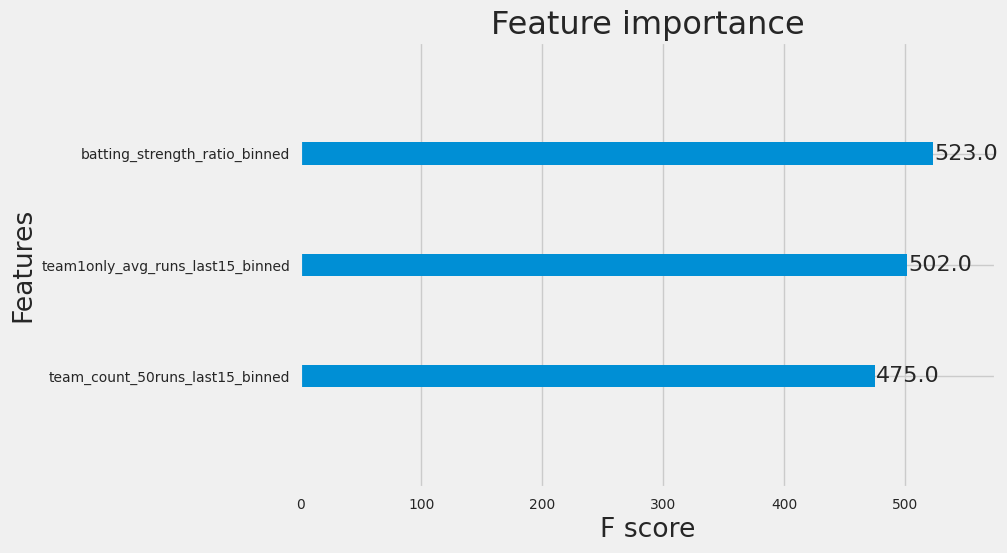

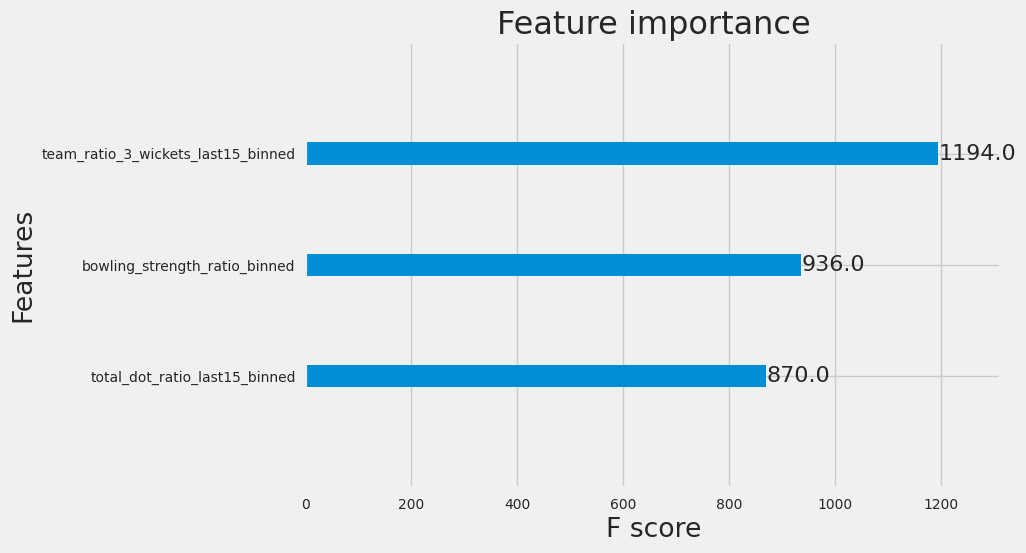

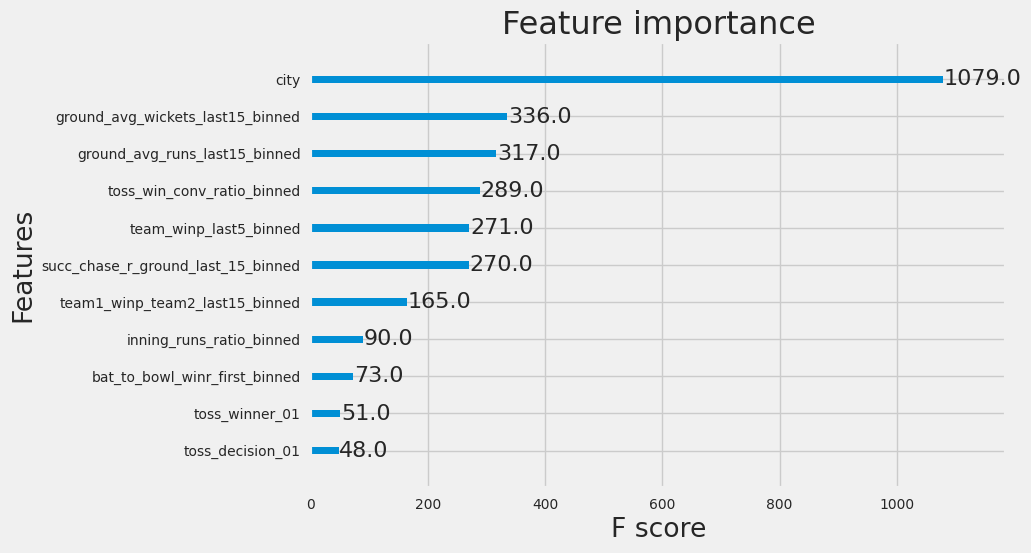

In [211]:
plot_importance(clf_1)
plot_importance(clf_2)
plot_importance(clf_3)

In [233]:
clf_3.feature_importances_

array([0.25987503, 0.2712565 , 0.25277194, 0.21609655], dtype=float32)

# Modeling 

In [10]:
train_data_binned.columns

Index(['Unnamed: 0', 'match id', 'team1', 'team1_id', 'team1_roster_ids',
       'team2', 'team2_id', 'team2_roster_ids', 'winner', 'winner_id',
       'toss winner', 'toss decision', 'venue', 'city', 'match_dt', 'lighting',
       'series_name', 'season', 'ground_id', 'winner_01', 'toss_winner_01',
       'toss_decision_01', 'team_count_50runs_last15_binned',
       'team_winp_last5_binned', 'team1only_avg_runs_last15_binned',
       'team1_winp_team2_last15_binned', 'ground_avg_runs_last15_binned',
       'ground_avg_wickets_last15_binned', 'inning_runs_ratio_binned',
       'succ_chase_r_ground_last_15_binned', 'bat_to_bowl_winr_first_binned',
       'team1_to_team2_total_wickets_ratio_binned',
       'team_ratio_3_wickets_last15_binned', 'total_dot_ratio_last15_binned',
       'batting_strength_ratio_binned', 'bowling_strength_ratio_binned',
       'team1_toss_win_conversion_binned', 'team2_toss_win_conversion_binned',
       'toss_win_conv_ratio_binned', 'team1_boundaries_last15']

In [12]:
train_data_binned[['winner_01', 'toss_winner_01',
       'toss_decision_01', 'team_count_50runs_last15_binned',
       'team_winp_last5_binned', 'team1only_avg_runs_last15_binned',
       'team1_winp_team2_last15_binned', 'ground_avg_runs_last15_binned',
       'ground_avg_wickets_last15_binned', 'inning_runs_ratio_binned',
       'succ_chase_r_ground_last_15_binned', 'bat_to_bowl_winr_first_binned',
       'team1_to_team2_total_wickets_ratio_binned',
       'team_ratio_3_wickets_last15_binned', 'total_dot_ratio_last15_binned',
       'batting_strength_ratio_binned', 'bowling_strength_ratio_binned',
       'team1_toss_win_conversion_binned', 'team2_toss_win_conversion_binned',
       'toss_win_conv_ratio_binned', 'team1_boundaries_last15']].corr()['winner_01']

winner_01                                    1.000000
toss_winner_01                              -0.039748
toss_decision_01                             0.032983
team_count_50runs_last15_binned             -0.154912
team_winp_last5_binned                      -0.124538
team1only_avg_runs_last15_binned            -0.028244
team1_winp_team2_last15_binned              -0.046719
ground_avg_runs_last15_binned               -0.024530
ground_avg_wickets_last15_binned             0.017339
inning_runs_ratio_binned                     0.049928
succ_chase_r_ground_last_15_binned          -0.060335
bat_to_bowl_winr_first_binned                0.013400
team1_to_team2_total_wickets_ratio_binned   -0.066364
team_ratio_3_wickets_last15_binned          -0.097683
total_dot_ratio_last15_binned               -0.138666
batting_strength_ratio_binned               -0.147612
bowling_strength_ratio_binned               -0.123756
team1_toss_win_conversion_binned            -0.098614
team2_toss_win_conversion_bi

In [26]:
train_data.columns

Index(['match id', 'team1', 'team1_id', 'team1_roster_ids', 'team2',
       'team2_id', 'team2_roster_ids', 'winner', 'winner_id', 'toss winner',
       'toss decision', 'venue', 'city', 'match_dt', 'lighting', 'series_name',
       'season', 'ground_id', 'team_count_50runs_last15', 'team_winp_last5',
       'team1only_avg_runs_last15', 'team1_winp_team2_last15',
       'ground_avg_runs_last15', 'winner_01', 'toss_winner_01',
       'toss_decision_01', 'ground_avg_wickets_last15', 'inning_runs_ratio',
       'succ_chase_r_ground_last_15', 'bat_to_bowl_winr_first',
       'team1_to_team2_total_wickets_ratio', 'team_ratio_3_wickets_last15',
       'total_dot_ratio_last15', 'batting_strength_ratio',
       'bowling_strength_ratio', 'team1_toss_win_conversion',
       'team2_toss_win_conversion', 'toss_win_conv_ratio',
       'team1_boundaries_last15', 'team2_boundaries_last15'],
      dtype='object')

In [34]:
features_with_target = [ 'team_count_50runs_last15', 'team_winp_last5',
       'team1only_avg_runs_last15', 'team1_winp_team2_last15',
       'ground_avg_runs_last15',  'toss_winner_01',
       'toss_decision_01', 'ground_avg_wickets_last15', 'inning_runs_ratio',
       'succ_chase_r_ground_last_15', 'bat_to_bowl_winr_first',
       'team1_to_team2_total_wickets_ratio', 'team_ratio_3_wickets_last15',
       'total_dot_ratio_last15', 'batting_strength_ratio',
       'bowling_strength_ratio', 'team1_toss_win_conversion',
       'team2_toss_win_conversion', 'toss_win_conv_ratio',
       'team1_boundaries_last15', 'team2_boundaries_last15']

In [28]:
train_data[features_with_target].corr()['winner_01']

team_count_50runs_last15             -0.110761
team_winp_last5                      -0.011712
team1only_avg_runs_last15            -0.047838
team1_winp_team2_last15              -0.055788
ground_avg_runs_last15               -0.012359
winner_01                             1.000000
toss_winner_01                       -0.039748
toss_decision_01                      0.032983
ground_avg_wickets_last15             0.008545
inning_runs_ratio                     0.073301
succ_chase_r_ground_last_15          -0.069501
bat_to_bowl_winr_first                0.033869
team1_to_team2_total_wickets_ratio   -0.051550
team_ratio_3_wickets_last15          -0.094717
total_dot_ratio_last15               -0.051658
batting_strength_ratio               -0.048402
bowling_strength_ratio               -0.053240
team1_toss_win_conversion            -0.082311
team2_toss_win_conversion             0.045480
toss_win_conv_ratio                  -0.082182
team1_boundaries_last15              -0.147493
team2_boundar

In [32]:
train_data['toss_win_conv_ratio_binned'] = train_data_binned['toss_win_conv_ratio_binned']

In [119]:
city_freq= (train_data.city.value_counts())
city_freq

city
Mumbai              40
Dhaka               31
Melbourne           29
London              27
Birmingham          25
                    ..
Raipur               1
Prague               1
The Hague            1
Alexandra            1
Palmerston North     1
Name: count, Length: 114, dtype: int64

In [120]:
city_freq

city
Mumbai              40
Dhaka               31
Melbourne           29
London              27
Birmingham          25
                    ..
Raipur               1
Prague               1
The Hague            1
Alexandra            1
Palmerston North     1
Name: count, Length: 114, dtype: int64

In [121]:
less_freq_city = city_freq[city_freq < 5]
less_freq_city

city
Sharjah               4
Bengaluru             4
Hyderabad             4
Canberra              4
Port of Spain         4
Cape Town             4
Hangzhou              4
Edinburgh             4
Dharamsala            3
Kirtipur              3
Hambantota            3
Doha                  3
Dunedin               3
New Plymouth          3
Mount Maunganui       3
Dublin                3
Queenstown            3
Multan                3
Launceston            3
Paarl                 3
Guwahati              3
Abu Dhabi             2
Visakhapatnam         2
Lauderhill            2
Thiruvananthapuram    2
Coffs Harbour         2
Blackpool             2
Chesterfield          2
Hamilton              2
Northwood             1
Whangarei             1
Cairns                1
Radlett               1
Nagpur                1
Napier                1
St George's           1
Nelson                1
Roseau                1
Albury                1
Carrara               1
Raipur                1
Prague     

In [122]:
# Create a list of all categories, including "other"
all_categories = list(city_freq.index) + ["other"]

# Set the categories for the 'city' column in train_data
train_data['city'] = pd.Categorical(train_data['city'], categories=all_categories)

# Now you can safely assign "other" to the less frequent cities
train_data.loc[train_data.city.isin(less_freq_city.index.tolist()), "city"] = "other"

In [40]:
feature = ['team_count_50runs_last15', 'total_dot_ratio_last15',
       'team1_boundaries_last15', 'bat_ratio'
      ]

In [29]:
#removing outliers 

for col in feature:
    col_mean=train_data[col].mean()
    col_std=train_data[col].std()
    lower_bound=col_mean-2*col_std
    upper_bound=col_mean+2*col_std
    
    train_data= train_data[(train_data[col]<upper_bound)&(train_data[col]>lower_bound)]

In [30]:
train_data['team1_boundaries_last15'] = train_data['team1_boundaries_last15']/train_data['team1_boundaries_last15'].max()

In [41]:
train_data['city'] = train_data['city'].astype('category')
train_data['lighting'] = train_data['lighting'].astype('category')

In [42]:
X,y = train_data[feature], train_data['winner_01']

In [43]:
X.isnull().sum()

team_count_50runs_last15    0
total_dot_ratio_last15      0
team1_boundaries_last15     0
bat_ratio                   0
dtype: int64

In [44]:
%%time
# using grid search for HyperParameter tuning
clf_xgb =XGBClassifier(enable_categorical = True)
clf_lgbm = LGBMClassifier(verbose = -1)
clf_GBM = GradientBoostingClassifier()
clf_cat = CatBoostClassifier(verbose = False)

from sklearn.model_selection import GridSearchCV

param_grid = {"max_depth":    [2,3,4,5],
              "n_estimators": [100,200,300,400,1000],
              "learning_rate": [0.001, 0.01, 0.1]}

# try out every combination of the above values
search1 = GridSearchCV(clf_xgb, param_grid, cv=5, scoring = 'accuracy').fit(X, y)
search2 = GridSearchCV(clf_lgbm, param_grid, cv=5, scoring = 'accuracy').fit(X, y)
search3 = GridSearchCV(clf_GBM, param_grid, cv=5, scoring = 'accuracy').fit(X, y)
search4 = GridSearchCV(clf_cat, param_grid, cv=5, scoring = 'accuracy').fit(X, y)


print("The best hyperparameters for XGB are ",search1.best_params_)
print("The best hyperparameters for LGBM are ",search2.best_params_)
print("The best hyperparameters for GBM are ",search3.best_params_)
print("The best hyperparameters for CatBoost are ",search4.best_params_)

The best hyperparameters for XGB are  {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 1000}
The best hyperparameters for LGBM are  {'learning_rate': 0.001, 'max_depth': 2, 'n_estimators': 400}
The best hyperparameters for GBM are  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
The best hyperparameters for CatBoost are  {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 400}
CPU times: user 10min 42s, sys: 1min 45s, total: 12min 28s
Wall time: 7min 29s


In [110]:
from sklearn.model_selection import StratifiedKFold,cross_val_score

skf = StratifiedKFold(n_splits=5,shuffle=True)

clf_xgb = XGBClassifier(learning_rate = search1.best_params_['learning_rate'],
                        n_estimators = search1.best_params_['n_estimators'],
                        max_depth = search1.best_params_['max_depth'],
                        enable_categorical = True,
                       )

clf_lgbm = LGBMClassifier(learning_rate = search2.best_params_['learning_rate'],
                        n_estimators = search2.best_params_['n_estimators'],
                        max_depth = search2.best_params_['max_depth'],verbose = -1)

clf_GBM = GradientBoostingClassifier(learning_rate = search3.best_params_['learning_rate'],
                                       n_estimators = search3.best_params_['n_estimators'],
                                       max_depth = search3.best_params_['max_depth'])

clf_cat = CatBoostClassifier(learning_rate = search4.best_params_['learning_rate'],
                           n_estimators = search4.best_params_['n_estimators'],
                           max_depth = search4.best_params_['max_depth'],verbose = False,)

clf_voting = VotingClassifier(estimators = [('xgb', clf_xgb), 
                                            ('cat', clf_cat), ],
                             voting = 'soft')

print('>>>>>>>>>Accuracy<<<<<<<<<<<<<')
print('XGB : ',cross_val_score(clf_xgb ,X,y,cv=skf,scoring="accuracy").mean())
print('LGBM : ',cross_val_score(clf_lgbm ,X,y,cv=skf,scoring="accuracy").mean())
print('GBM : ',cross_val_score(clf_GBM ,X,y,cv=skf,scoring="accuracy").mean())
print('cat : ',cross_val_score(clf_cat ,X,y,cv=skf,scoring="accuracy").mean())
print('Ensemble_Voting : ',cross_val_score(clf_voting ,X,y,cv=skf,scoring="accuracy").mean())

>>>>>>>>>Accuracy<<<<<<<<<<<<<
XGB :  0.5458333333333333
LGBM :  0.5645676100628931
GBM :  0.5696698113207547
cat :  0.5758254716981133
Ensemble_Voting :  0.5809512578616353


In [121]:
X_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

In [122]:
clf_xgb = XGBClassifier(learning_rate = search1.best_params_['learning_rate'],
                        n_estimators = search1.best_params_['n_estimators'],
                        max_depth = search1.best_params_['max_depth'],
                        enable_categorical = True)

clf_lgbm = LGBMClassifier(learning_rate = search2.best_params_['learning_rate'],
                        n_estimators = search2.best_params_['n_estimators'],
                        max_depth = search2.best_params_['max_depth'],verbose = -1)

clf_GBM = GradientBoostingClassifier(learning_rate = search3.best_params_['learning_rate'],
                                       n_estimators = search3.best_params_['n_estimators'],
                                       max_depth = search3.best_params_['max_depth'])

clf_cat = CatBoostClassifier(learning_rate = search4.best_params_['learning_rate'],
                           n_estimators = search4.best_params_['n_estimators'],
                           max_depth = search4.best_params_['max_depth'],verbose = False,)

clf_voting = VotingClassifier(estimators = [('xgb', clf_xgb),
                                            ('cat', clf_cat), ('GBM', clf_GBM)],
                             voting = 'soft')


In [123]:
eval_set = [(X_train, y_train),(x_test, y_test)]

In [124]:
clf_xgb.fit(X_train,y_train, eval_set = eval_set, verbose = False)
clf_lgbm.fit(X_train,y_train, eval_set = eval_set)
clf_GBM.fit(X_train,y_train)
clf_cat.fit(X_train,y_train)
clf_voting.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

LGBMClassifier(learning_rate=0.001, max_depth=2, n_estimators=400, verbose=-1)

GradientBoostingClassifier(learning_rate=0.01)

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=3,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=1000, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('cat',
                              <catboost.core.CatBoostClassifier object at 0x7edce4b65660>),
                             ('GBM',
                              GradientBoostingClassifier(learning_rate=0.01))],
                 voting='soft')

In [125]:
from sklearn.metrics import classification_report
print("training Report\n",classification_report(y_train, clf_xgb.predict(X_train)),'\n')
print("training Report\n",classification_report(y_test, clf_xgb.predict(x_test)),'\n')
print("Test Report\n",classification_report(y_test, clf_lgbm.predict(x_test)),'\n')
print("training Report\n",classification_report(y_test, clf_GBM.predict(x_test)),'\n')
print("Test Report\n",classification_report(y_test, clf_cat.predict(x_test)),'\n')
print("Test Report\n",classification_report(y_test, clf_voting.predict(x_test)),'\n')

training Report
               precision    recall  f1-score   support

           0       0.63      0.85      0.72       335
           1       0.72      0.44      0.55       302

    accuracy                           0.65       637
   macro avg       0.67      0.64      0.63       637
weighted avg       0.67      0.65      0.64       637
 

training Report
               precision    recall  f1-score   support

           0       0.51      0.82      0.63        68
           1       0.76      0.42      0.55        92

    accuracy                           0.59       160
   macro avg       0.64      0.62      0.59       160
weighted avg       0.66      0.59      0.58       160
 

Test Report
               precision    recall  f1-score   support

           0       0.49      0.88      0.63        68
           1       0.78      0.32      0.45        92

    accuracy                           0.56       160
   macro avg       0.64      0.60      0.54       160
weighted avg       0.66

In [126]:
#feature importance
feat_importance = pd.DataFrame({'feat_name':X.columns.tolist()})
feat_importance['model_feat_imp_train_XGB'] = clf_xgb.feature_importances_
feat_importance['model_feat_imp_train_lgbm'] = clf_lgbm.feature_importances_
feat_importance['model_feat_imp_train_GBM'] = clf_GBM.feature_importances_
feat_importance['model_feat_imp_train_cat'] = clf_cat.get_feature_importance()

feat_importance


,feat_name,model_feat_imp_train_XGB,model_feat_imp_train_lgbm,model_feat_imp_train_GBM,model_feat_imp_train_cat
0,team_count_50runs_last15,0.281840,272,0.214273,27.010515
1,total_dot_ratio_last15,0.259377,541,0.406196,27.416028
2,team1_boundaries_last15,0.237268,304,0.226456,24.843611
3,bat_ratio,0.221515,83,0.153075,20.729846


In [131]:
clf_xgb = XGBClassifier(learning_rate = search1.best_params_['learning_rate'],
                        n_estimators = search1.best_params_['n_estimators'],
                        max_depth = search1.best_params_['max_depth'],
                        enable_categorical = True)

clf_cat = CatBoostClassifier(learning_rate = search4.best_params_['learning_rate'],
                           n_estimators = search4.best_params_['n_estimators'],
                           max_depth = search4.best_params_['max_depth'],verbose = False,)
clf_voting = VotingClassifier(estimators = [('xgb', clf_xgb), 
                                            ('cat', clf_cat), ],
                             voting = 'soft')

#evaluating
eval_set = [(x_test, y_test), (X_train, y_train)]
clf_xgb.fit(X_train,y_train, eval_set = eval_set, verbose = False)
clf_cat.fit(X,y, eval_set = eval_set, verbose = False)
clf_voting.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.001, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=3,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=1000, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('cat',
                              <catboost.core.CatBoostClassifier object at 0x7edcdb708a90>)],
                 voting='soft')

Text(0, 0.5, 'logloss')

Text(0.5, 1.0, 'XGBoost logloss')

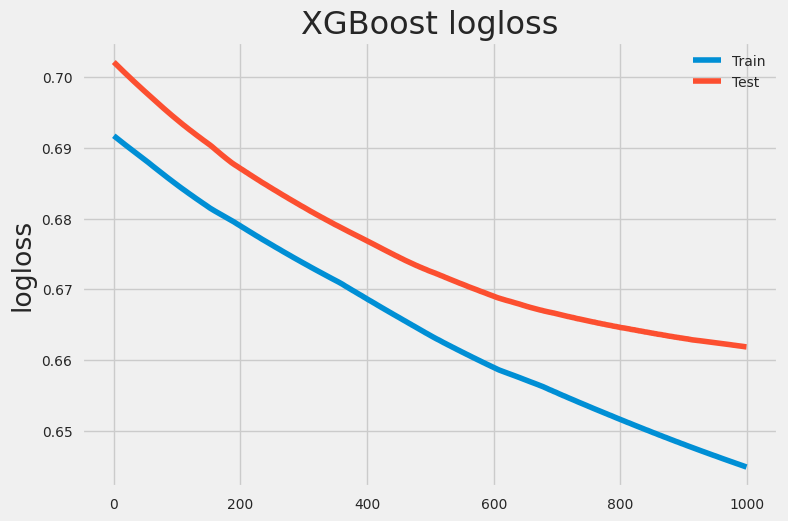

In [132]:
# retrieve performance metrics
results = clf_xgb.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_1']['logloss'], label='Train')
ax.plot(x_axis, results['validation_0']['logloss'], label='Test')
ax.legend()
plt.ylabel('logloss')
plt.title('XGBoost logloss')
plt.show()

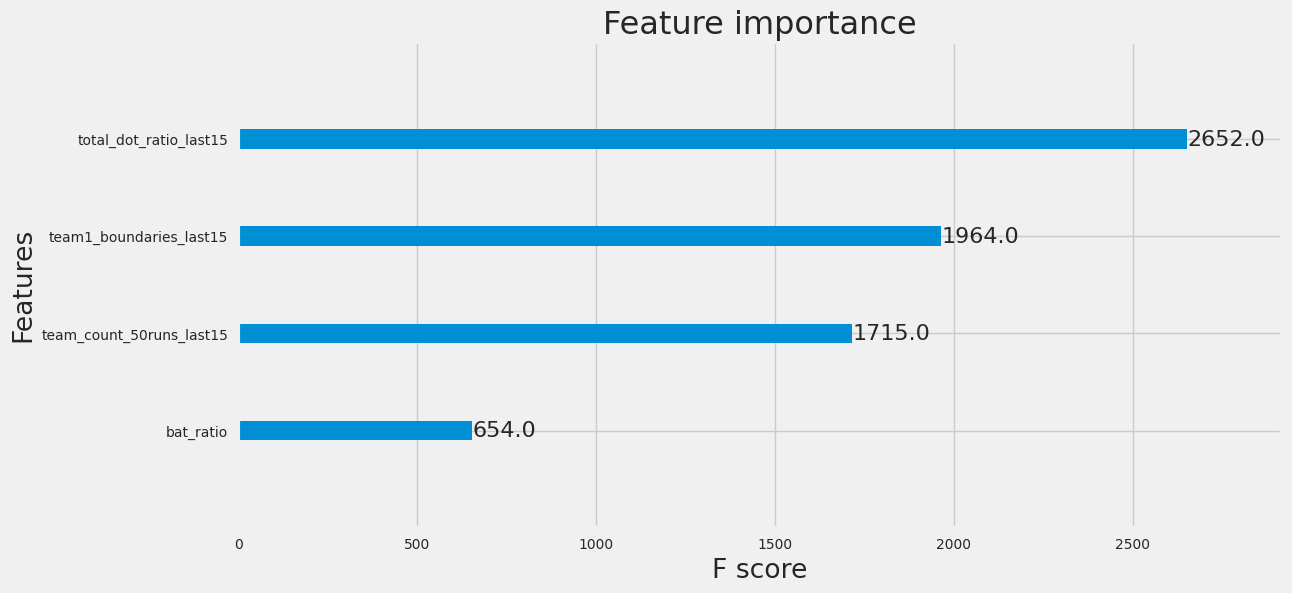

In [133]:
#plotting feature importance
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(12,6))
plot_importance(clf_xgb, ax=ax)
plt.show();

In [134]:
from sklearn.metrics import classification_report

# Train accuracy
print("training Report\n",classification_report(y_train, clf_xgb.predict(X_train)),'\n')
print("Test Report\n",classification_report(y_test, clf_xgb.predict(x_test)),'\n')
print("training Report\n",classification_report(y_train, clf_cat.predict(X_train)),'\n')
print("Test Report\n",classification_report(y_test, clf_cat.predict(x_test)),'\n')
print("training Report\n",classification_report(y_train, clf_voting.predict(X_train)),'\n')
print("Test Report\n",classification_report(y_test, clf_voting.predict(x_test)),'\n')

training Report
               precision    recall  f1-score   support

           0       0.63      0.85      0.72       335
           1       0.72      0.44      0.55       302

    accuracy                           0.65       637
   macro avg       0.67      0.64      0.63       637
weighted avg       0.67      0.65      0.64       637
 

Test Report
               precision    recall  f1-score   support

           0       0.51      0.82      0.63        68
           1       0.76      0.42      0.55        92

    accuracy                           0.59       160
   macro avg       0.64      0.62      0.59       160
weighted avg       0.66      0.59      0.58       160
 

training Report
               precision    recall  f1-score   support

           0       0.72      0.82      0.76       335
           1       0.76      0.64      0.70       302

    accuracy                           0.73       637
   macro avg       0.74      0.73      0.73       637
weighted avg       0.74

# Stacking

In [94]:
X, y = train_data[feature], train_data['winner_01']
X_train, x_test, y_train, y_test = train_test_split(X,y)

In [95]:
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn import model_selection 

> Level 0 Classifiers

In [96]:
#level 0 classifiers
clf_1 = XGBClassifier(learning_rate = search1.best_params_['learning_rate'],
                        n_estimators = search1.best_params_['n_estimators'],
                        max_depth = search1.best_params_['max_depth'],
                        enable_categorical = True)

clf_2 = LGBMClassifier(learning_rate = search2.best_params_['learning_rate'],
                        n_estimators = search2.best_params_['n_estimators'],
                        max_depth = search2.best_params_['max_depth'],verbose = -1)

clf_3 = GradientBoostingClassifier(learning_rate = search3.best_params_['learning_rate'],
                                       n_estimators = search3.best_params_['n_estimators'],
                                       max_depth = search3.best_params_['max_depth'])

clf_4 = CatBoostClassifier(learning_rate = search4.best_params_['learning_rate'],
                           n_estimators = search4.best_params_['n_estimators'],
                           max_depth = search4.best_params_['max_depth'],verbose = False,)

In [97]:
classifiers = {
    "XGB": clf_1,
    "lightgbm": clf_2,
    "GBM": clf_3,
    "catboost": clf_4,
}

> Level 1 Classifier - Meta Classifier

In [98]:
#level 1 classifier
mlr = XGBClassifier()

> Cross-validating and training level 0 classifiers

In [99]:
%%time
# This step could take some time .... it depends on classifiers you use .... So make a coffe or meditate ... 

models_scores_results, models_names = list(), list() 

print(">>>> Training started <<<<")
for key in classifiers:
    classifier = classifiers[key]
    scores = model_selection.cross_val_score(classifier, X, y, cv = 5, scoring='accuracy')
    models_scores_results.append(scores)
    models_names.append(key)
    print("[%s] - accuracy: %0.5f " % (key, scores.mean()))
    classifier.fit(X_train, y_train)
    
    # Save classifier for prediction 
    classifiers[key] = classifier

>>>> Training started <<<<
[XGB] - accuracy: 0.59220 
[lightgbm] - accuracy: 0.59968 
[GBM] - accuracy: 0.58715 
[catboost] - accuracy: 0.59716 
CPU times: user 11.8 s, sys: 2.7 s, total: 14.5 s
Wall time: 6.75 s


In [100]:
# This function searches best stacking configuration
def best_stacking_search():
    cls_list = []
    best_auc = -1
    i=0

    best_cls_experiment = list()

    print(">>>> Training started <<<<")

    for cls_comb in range(2, len(taken_classifiers)+1):
        for subset in itertools.combinations(taken_classifiers, cls_comb):
            cls_list.append(subset)

    print(f"Total number of model combination: {len(cls_list)}")


    for cls_exp in cls_list:
        cls_labels = list(cls_exp)

        classifier_exp = []
        for ii in range(len(cls_labels)):
            label = taken_classifiers[ii]
            classifier = classifiers[label]
            classifier_exp.append(classifier)


        sclf = StackingCVClassifier(classifiers = classifier_exp,
                                    shuffle = False,
                                    use_probas = True,
                                    cv = 5,
                                    meta_classifier = mlr,
                                    n_jobs = -1)

        scores = model_selection.cross_val_score(sclf, X, y, cv = 5, scoring='accuracy')

        if scores.mean() > best_auc:
            best_cls_experiment = list(cls_exp)
        i += 1
        print(f"  {i} - Stacked combination - Acc {cls_exp}: {scores.mean():.5f}")
        
    return best_cls_experiment

In [101]:
taken_classifiers = ["XGB",
    "GBM",
    "catboost",
    "lightgbm",]

In [102]:
import itertools   
from mlxtend.classifier import StackingCVClassifier
best_cls_experiment = best_stacking_search()

>>>> Training started <<<<
Total number of model combination: 11
  1 - Stacked combination - Acc ('XGB', 'GBM'): 0.52943
  2 - Stacked combination - Acc ('XGB', 'catboost'): 0.55079
  3 - Stacked combination - Acc ('XGB', 'lightgbm'): 0.54577
  4 - Stacked combination - Acc ('GBM', 'catboost'): 0.55708
  5 - Stacked combination - Acc ('GBM', 'lightgbm'): 0.53447
  6 - Stacked combination - Acc ('catboost', 'lightgbm'): 0.53574
  7 - Stacked combination - Acc ('XGB', 'GBM', 'catboost'): 0.54072
  8 - Stacked combination - Acc ('XGB', 'GBM', 'lightgbm'): 0.53443
  9 - Stacked combination - Acc ('XGB', 'catboost', 'lightgbm'): 0.53566
  10 - Stacked combination - Acc ('GBM', 'catboost', 'lightgbm'): 0.53067
  11 - Stacked combination - Acc ('XGB', 'GBM', 'catboost', 'lightgbm'): 0.54447


In [103]:
best_cls_experiment = ['XGB', 'GBM', 'catboost', 'lightgbm']

In [104]:
print(f'The best models configuration: {best_cls_experiment}')

classifier_exp = []
for label in best_cls_experiment:
        classifier = classifiers[label]
        classifier_exp.append(classifier)

The best models configuration: ['XGB', 'GBM', 'catboost', 'lightgbm']


In [105]:
scl = StackingCVClassifier(classifiers= classifier_exp,
                            meta_classifier = mlr, # use meta-classifier
                            use_probas = False,   # use_probas = True/False
                            random_state = 2024)

scores = model_selection.cross_val_score(scl, X, y, cv = 5, scoring='accuracy')
models_scores_results.append(scores)
models_names.append('scl')
print("Meta model (slc) - accuracy: %0.5f " % (scores.mean()))
scl.fit(X_train, y_train)

top_meta_model = scl
base_acc = scores.mean()

Meta model (slc) - accuracy: 0.56451 


StackingCVClassifier(classifiers=[XGBClassifier(base_score=None, booster=None,
                                                callbacks=None,
                                                colsample_bylevel=None,
                                                colsample_bynode=None,
                                                colsample_bytree=None,
                                                device=None,
                                                early_stopping_rounds=None,
                                                enable_categorical=True,
                                                eval_metric=None,
                                                feature_types=None, gamma=None,
                                                grow_policy=None,
                                                importance_type=None,
                                                interaction_constraints=None,
                                                learning_rate=...
                                                   importance_type=None,
                                                   interaction_constraints=None,
                                                   learning_rate=None,
                                                   max_bin=None,
                                                   max_cat_threshold=None,
                                                   max_cat_to_onehot=None,
                                                   max_delta_step=None,
                                                   max_depth=None,
                                                   max_leaves=None,
                                                   min_child_weight=None,
                                                   missing=nan,
                                                   monotone_constraints=None,
                                                   multi_strategy=None,
                                                   n_estimators=None,
                                                   n_jobs=None,
                                                   num_parallel_tree=None,
                                                   random_state=None, ...),
                     random_state=2024)

In [106]:
classifiers["scl"] = top_meta_model

In [107]:
from sklearn import metrics

In [108]:
for key in classifiers:
    y_pred = classifiers[key].predict_proba(x_test)[:,1]
    auc = metrics.roc_auc_score(y_test, y_pred)
    print(f"{key} -> AUC: {auc:.5f}")
    y_pred1 = classifiers[key].predict(x_test)
    print( metrics.classification_report(y_test, y_pred1))

XGB -> AUC: 0.58439
              precision    recall  f1-score   support

           0       0.53      0.72      0.61        96
           1       0.61      0.40      0.49       104

    accuracy                           0.56       200
   macro avg       0.57      0.56      0.55       200
weighted avg       0.57      0.56      0.54       200

lightgbm -> AUC: 0.62385
              precision    recall  f1-score   support

           0       0.56      0.82      0.67        96
           1       0.71      0.40      0.52       104

    accuracy                           0.60       200
   macro avg       0.64      0.61      0.59       200
weighted avg       0.64      0.60      0.59       200

GBM -> AUC: 0.61483
              precision    recall  f1-score   support

           0       0.51      0.71      0.59        96
           1       0.58      0.38      0.46       104

    accuracy                           0.54       200
   macro avg       0.55      0.54      0.53       200
weighted 

# Best Model

In [136]:
best_model = clf_cat

In [135]:
# user-defined parameters

algo_name = 'Catboost'
is_ensemble = 'no'
n_trees = '400'
depth = '5'
lr = '0.01'

# Preparing the test data for prediction

In [137]:
test_data.columns

Index(['match id', 'team1', 'team1_id', 'team1_roster_ids', 'team2',
       'team2_id', 'team2_roster_ids', 'toss winner', 'toss decision', 'venue',
       'city', 'match_dt', 'lighting', 'series_name', 'season', 'ground_id',
       'team_count_50runs_last15', 'team_winp_last5',
       'team1only_avg_runs_last15', 'team1_winp_team2_last15',
       'ground_avg_runs_last15', 'toss_winner_01', 'toss_decision_01',
       'ground_avg_wickets_last15', 'inning_runs_ratio',
       'succ_chase_r_ground_last_15', 'team1_to_team2_total_wickets_ratio',
       'team_ratio_3_wickets_last15', 'total_dot_ratio_last15',
       'bat_to_bowl_winr_first', 'team1_boundaries_last15',
       'team2_boundaries_last15', 'bowling_strength_ratio',
       'batting_strength_ratio', 'team1_toss_win_conversion',
       'team2_toss_win_conversion', 'toss_win_conv_ratio',
       'strength_team1_batting', 'strength_team2_batting', 'bat_ratio'],
      dtype='object')

In [138]:
X_test = test_data[feature]

# File Preparation

> Feature Importance

In [142]:
df_feat_importance = pd.DataFrame({'feat_name':X.columns.tolist(), 'model_feat_imp_train': (clf_cat.feature_importances_/sum(clf_cat.feature_importances_))}).sort_values(by='model_feat_imp_train', ascending=False)\
                                                                                                                       .reset_index(drop=True)
df_feat_importance

,feat_name,model_feat_imp_train
0,total_dot_ratio_last15,0.274350
1,team_count_50runs_last15,0.265741
2,team1_boundaries_last15,0.246371
3,bat_ratio,0.213538


> Submission code

In [143]:
train_data['win_pred_score'] = best_model.predict_proba(X)[:,1]
test_data['win_pred_score'] = best_model.predict_proba(X_test)[:,1]

Getting win_pred_score corresponding to winner team

In [144]:
train_data['y_pred_01'] = best_model.predict(X)
test_data['y_pred_01'] = best_model.predict(X_test)

In [145]:
train_data['win_pred_score'] = np.where( (train_data['y_pred_01']==0), (1-train_data['win_pred_score']), train_data['win_pred_score'])
test_data['win_pred_score'] = np.where( (test_data['y_pred_01']==0), (1-test_data['win_pred_score']), test_data['win_pred_score'])

Getting winner_team_id from custom dependent column

In [146]:
train_data['win_pred_team_id'] = np.where( (train_data['y_pred_01']==0), (train_data['team1_id']), train_data['team2_id'])
test_data['win_pred_team_id'] = np.where( (test_data['y_pred_01']==0), (test_data['team1_id']), test_data['team2_id'])

>  File 1

In [147]:
train_data['dataset_type'] = 'train'
test_data['dataset_type'] = 'r1'

In [148]:
## refactor

df_file1 = pd.concat([test_data[['match id','dataset_type','win_pred_team_id','win_pred_score',] + list(df_feat_importance['feat_name'].head(10))], \
                     train_data[['match id','dataset_type','win_pred_team_id','win_pred_score',] + list(df_feat_importance['feat_name'].head(10))]])

renaming_dict = {}
for i,col in enumerate(list(df_feat_importance['feat_name'].head(10))):
    renaming_dict[col] = f'indep_feat_id{i+1}'
df_file1.rename(columns=renaming_dict, inplace=True)

for i in range(1,11):
    if f'indep_feat_id{i}' not in df_file1.columns:
        df_file1[f'indep_feat_id{i}'] = np.nan

df_file1['train_algorithm'] = algo_name
df_file1['is_ensemble'] = is_ensemble
df_file1['train_hps_trees'] = n_trees
df_file1['train_hps_depth'] = depth
df_file1['train_hps_lr'] = lr

In [149]:
df_file1.shape
df_file1.head()

(1068, 19)

,match id,dataset_type,win_pred_team_id,win_pred_score,indep_feat_id1,indep_feat_id2,indep_feat_id3,indep_feat_id4,indep_feat_id5,indep_feat_id6,indep_feat_id7,indep_feat_id8,indep_feat_id9,indep_feat_id10,train_algorithm,is_ensemble,train_hps_trees,train_hps_depth,train_hps_lr
0,9250275,r1,90,0.733361,0.008475,0.000000,3.0,0.128692,NaN,NaN,NaN,NaN,NaN,NaN,Catboost,no,400,5,0.01
1,9262189,r1,36098,0.510642,0.785436,0.615385,94.0,0.942483,NaN,NaN,NaN,NaN,NaN,NaN,Catboost,no,400,5,0.01
2,9128776,r1,30428,0.594825,0.998801,0.842105,125.0,0.927054,NaN,NaN,NaN,NaN,NaN,NaN,Catboost,no,400,5,0.01
3,9586919,r1,36098,0.722982,1.178236,0.285714,89.0,0.881235,NaN,NaN,NaN,NaN,NaN,NaN,Catboost,no,400,5,0.01
4,9128538,r1,30414,0.809622,1.077033,2.375000,129.0,1.269090,NaN,NaN,NaN,NaN,NaN,NaN,Catboost,no,400,5,0.01


> File 2

In [150]:
feature_desc = {'total_dot_ratio_last15': 'Ratio of total number of dot balls conceded by the bowlers of team1 to the the bowlers of team2 in last 15 matches',\
    'team_count_50runs_last15':'Ratio of number of 50s by players in team1 to number of 50s by players in team2 in last 15 games',\
    'team1_boundaries_last15' : 'Number of total boundaries (Fours and Sixes) scored by team1 in last 15 games',
                'bat_ratio' : 'Ratio of batting strength(team1:team2). Batting strength is weighted sum of average team runs and average team Strike rate'
                }

In [151]:
# df_feat_importance.rename(index={0:'feat_id'}, inplace=True)
df_file2 = df_feat_importance
df_file2['feat_id'] = [i+1 for i in df_file2.index]
df_file2['feat_rank_train'] = [i+1 for i in df_file2.index]
df_file2 = df_file2.set_index('feat_id')
df_file2['feat_description'] = df_file2['feat_name'].map(feature_desc)

In [152]:
df_file2

,feat_name,model_feat_imp_train,feat_rank_train,feat_description
feat_id,,,,
1,total_dot_ratio_last15,0.274350,1,Ratio of total number of dot balls conceded by...
2,team_count_50runs_last15,0.265741,2,Ratio of number of 50s by players in team1 to ...
3,team1_boundaries_last15,0.246371,3,Number of total boundaries (Fours and Sixes) s...
4,bat_ratio,0.213538,4,Ratio of batting strength(team1:team2). Battin...


In [153]:
df_file2.shape

(4, 4)

> Save

In [154]:
df_file1.to_csv('2024_DS_Track_File1_TripleAAA.csv', index=False)
df_file2.to_csv('2024_DS_Track_File2_TripleAAA.csv')